In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import shutil
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.tseries.offsets import MonthEnd

### updates 2022-03-31

- add freq options ['M', 'Q']

### By platform/sector: show time series of # of user, # of orders, # of GMV
    ```
    get_time_series_of_user_basics
    inputs: 
        sector: str
            ['Ride Hailing', 'Food Delivery', 'eCommerce']
        country_list:
            list of country names
        platforms: default None
            platform list or None
            if platforms != None & group by = 'sector'
            will give a sector summary including only selected platform
        group_by:
            ['sector', 'platform']
        chart_groupby: 
            ['platform', 'country']
     Returns
        Plot 3 charts respectively (1 sector/platform per chart
        1 dataframe for # of user, # of orders, GMV group by country, month, sector/platform
     ```

### By Platform/sector: show decomposition of # of user, # of GMV by user cohort

    ```
    get_decomposition_by_cohorts
    inputs:
        sector: str
        country: str
        platforms: list default = None, include all available platforms under the sector


    Returns    
        2 charts: time series of # of users & GMV 
        by cohorts: churned, new, resurrected, retained 
        2 dataframes of # of users & GMV  respectively

    ```
### Overlapping Platforms
    - breakdown of users by # of platforms
    ```
    using_platforms_time_series
    inputs: 
        country: str
        sector: str
        platforms: list default = None, include all available platforms in selected country
        
    Returns
        stacked bar chart time series
        df for users breakdown by # of platforms using
    
    ```
    
    - given a selected platform, show the user overlap with other platforms (% of user also use platform X)

    ```
    overlapping_platforms_given_platform
    inputs: 
        country: str
        sector: str the sector to look at
        given_platform: str
        
    Returns
        grouped bar chart time series
        df for overlapping pct

    ```

### New users inflows

show the inflows of a given platform's new users

```
def get_new_user_sources(given_platform, country, sectors=None, platforms=None):
    '''
    inflow definition:
        for period t, this process assign 1 of the following label to a user
        previous user for platform X: a previous user is who was active at platform X in any period t' if t'<t
        multiple-platform user: a user counts as previous user for more than 1 platform
        new-to-sector user: the user can not count as previous user for any competitor platform


    :param given_platform: str, platform's new users to break down on
    :param country: str
    :param sectors: list default=None, the sectors the given platform in
    :param platforms: list default = None, include all available platforms under the sector
    :return:
        2 charts:
            time series of
                - # of new users
                - pct of new users inflow breakdown
        & 2 dataframes respectively
    hardcoded as a monthly aggregarion
    '''
```

In [2]:
box_folder = os.getcwd()
# r'{path}' for windows
RAW_DATA_FOLDER = os.path.join(box_folder, 'folder_name')

In [3]:
''' make (ALREADY CREATED) a processed data folder in BOX'''

''' or make a local folder here instead and run preprocess_data_to_parquet'''
base_folder = box_folder
PROCESSED_DATA_FOLDER = os.path.join(base_folder, 'processed_data_0307')
if not os.path.exists(PROCESSED_DATA_FOLDER):
    os.mkdir(PROCESSED_DATA_FOLDER)
PARQUET_FOLDER = os.path.join(PROCESSED_DATA_FOLDER, 'parquet_folder')
if not os.path.exists(PARQUET_FOLDER):
    os.mkdir(PARQUET_FOLDER)

In [4]:
SECTOR_COMPANY = {'eCommerce': ['Lazada', 'MagazineLuiza', 'Mercadolibre', 'Shein', 'Shopee', 'Tokopedia'],
                  'Food Delivery': ['Deliveroo', 'Foodpanda', 'GrabFood'],
                  'Ride Hailing': ['Grab', 'GoJek']}
''' CONFIG '''
USER_ID ='accountEmailId'
DATE_COL = 'receivedDate'
GMV_COL = 'totalChargedUSD'
ORDER_ID = 'orderId'
SECTOR_COL = 'sector'
PLATFORM_COL = 'platform'
COUNTRY_COL = 'country'

DATE_COL_DICT = {'M': 'month',
                 'Q': 'quarter'}

''' preprocess '''
FILTER_CONDITION = 'isSyncing==True'

In [5]:
def preprocess_data_to_parquet():
    '''
    filters isSyncing==True
    converts time to datetime
    assigns platform & sectors
    partitions data into ['country', 'sector', 'platform']
    '''

    files = [i for i in os.listdir(RAW_DATA_FOLDER) if '.csv' in i]
    ''' get platform name'''
    companies = {i: i.split('_')[1].replace('ReceiptData', '').replace('Ecommerce', '') for i in files}

    # unmatched = [k for k in list(companies.values()) if k not in sum(list(SECTOR_COMPANY.values()), [])]
    # check if there are any unmatched strings
    sector_company_map = {v: k for k, vals in SECTOR_COMPANY.items() for v in vals}
    for f in companies:
        d = pd.read_csv(os.path.join(RAW_DATA_FOLDER, f), low_memory=False).query(FILTER_CONDITION)
        platform = companies.get(f)
        d[PLATFORM_COL] = platform
        d[SECTOR_COL] = sector_company_map.get(platform)
        d[DATE_COL] = pd.to_datetime(d[DATE_COL], unit='s')
        d = d[[USER_ID, DATE_COL, 'country', SECTOR_COL, PLATFORM_COL, GMV_COL, ORDER_ID, 'isSyncing']]
        d.to_parquet(PARQUET_FOLDER, partition_cols=['country', SECTOR_COL, PLATFORM_COL])

#todo figure out why this doesn't work with jupyter notebook
# files = os.listdir(PARQUET_FOLDER)
# if files:
#     raise NameError('%s has some files already, plz see if it is safe to remove the folder %s' %
#                     (PARQUET_FOLDER, files))
# shutil.rmtree(PARQUET_FOLDER)
# preprocess_data_to_parquet()

In [5]:
# Helper function
def get_resampled_date(freq, dates):
    '''
     helper function
    - get month end or quarter end
    :param freq:  ['M', 'Q']
    :param d: date string
    :return: the date series
    '''
    offsetter_dict = {'M': pd.offsets.MonthEnd(0),
                      'Q': pd.offsets.QuarterEnd(0),
                      }
    offsetter = offsetter_dict.get(freq)
    if offsetter is None:
        raise ValueError('freq is not in ["M", "Q"]')
    return list(map(lambda i: (i + offsetter).date(), dates))
def get_raw_data(sector, platforms, country_list):
    '''
    a helper function here

    Parameters
    ----------
    sector str
    platforms list of platform
    country_list list of country

    Returns
    -------

    '''

    data = []
    for country in country_list:
        country_folder = os.path.join(PARQUET_FOLDER, f'{COUNTRY_COL}={country}')
        sector_folder = os.path.join(country_folder, f'{SECTOR_COL}={sector}')
        if not os.path.exists(sector_folder):
            print('%s is not availbel for %s' % (sector, country))
            continue
        if platforms is None:
            platforms = SECTOR_COMPANY.get(sector)
        for platform in platforms:
            platform_folder = os.path.join(sector_folder, f'platform={platform}')
            if not os.path.exists(platform_folder):
                continue
            df = pd.read_parquet(platform_folder)
            df[PLATFORM_COL] = platform
            df[SECTOR_COL] = sector
            df[COUNTRY_COL] = country
            data.append(df)
        ''' 
        if platforms is not None:
            if set(platforms) == SECTOR_COMPANY.get(sector):
                platforms = None
        if platforms is not None:
            for platform in platforms:
                platform_folder = os.path.join(sector_folder, f'platform={platform}')
                df = pd.read_parquet(platform_folder)
                df = df[df.country.isin(country_list)]
                df['platform'] = platform
                df['sector'] = sector
                data.append(df)
        else:
            df = pd.read_parquet(sector_folder)
            df['platform'] = df['platform'].astype(str)
            df['sector'] = sector
            data.append(df)
        '''
    df = pd.concat(data)
    return df

def get_any_sector_raw_df(given_platform, country, sectors, platforms):
    output = []
    to_read = {}
    sector_map = {v: k for k, vals in SECTOR_COMPANY.items() for v in vals}
    sector = sector_map.get(given_platform)
    country_folder = os.path.join(PARQUET_FOLDER, f'{COUNTRY_COL}={country}')
    platform_path = os.path.join(country_folder, f'{SECTOR_COL}={sector}', f'{PLATFORM_COL}={given_platform}')
    if not os.path.exists(platform_path):
        available_list = os.listdir(os.path.join(country_folder, f'{SECTOR_COL}={sector}'))
        raise IOError('given platform %s is not available for country %s, available entity of the sectors are %s' % (
            given_platform, country, available_list))
    to_read.update({sector: [given_platform]})

    if platforms is not None:
        for p in platforms:
            sector = sector_map.get(p)
            appended = to_read.get(sector, [])
            appended.append(p)
            to_read[sector] = appended

    elif sectors is not None:
        # sectors = SECTOR_COMPANY.keys()
        for sector in sectors:
            platforms = [i for i in SECTOR_COMPANY.get(sector) if i != given_platform]
            appended = to_read.get(sector, [])
            appended.extend(platforms)
            to_read[sector] = appended
    else:
        sector = sector_map.get(given_platform)
        to_read[sector] = None

    for sector, platforms in to_read.items():
        output.append(get_raw_data(sector, platforms, [country]))
    df = pd.concat(output)
    return df, to_read

In [6]:
FONT_SIZE={'legend': 30,
           'title': 40,
           'axis_label':40,
           'axis_tick': 30,
           'fig_ratio':(30,18)
           }
#plotting function

def plot_series_1_chart(df, x_col, y_col, hue_col, title, y_label, x_label='month', lengend_loc='best'):
    '''
    lengend_loc ['upper right', 'upper left']

    '''
    plt.close()
    fig, ax1 = plt.subplots(figsize=FONT_SIZE['fig_ratio'])
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue_col)

    plt.legend(fontsize=FONT_SIZE['legend'], loc=lengend_loc)
    ax1.yaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    ax1.xaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])

    ax1.set_xlabel(x_label, fontsize=FONT_SIZE['axis_label'])
    ax1.set_ylabel(y_label, fontsize=FONT_SIZE['axis_label'])
    # ax1.text(21212, 0.75, 'top 21212 creators (4.9%) contribute to 80% viewship', fontsize=28, color='orange')
    # h = plt.gca().get_lines()
    # lg = plt.legend(handles=h, labels=['normal_projects','pro_projects'], loc='best', fontsize=22)
    # 'normal_projects_creators', 'pro_projects','pro_projects_creators' ], loc='best', fontsize=22)
    plt.title(title, fontsize=FONT_SIZE['title'])
    plt.tight_layout()
    plt.show()


def plot_user_corhort_chart(df, date_col, title, y_col='# of users', x_col='month', lengend_loc='best'):
    '''
    get a stacked bar chart with negative bar
    - recalculate the data in display layers

    '''

    color_palette = {'churned': '#3F681C',
                     'new': '#FFBB00',
                     'resurrected': '#FB6542',
                     'retained': '#375E97'}

    plt.close()
    fig, ax1 = plt.subplots(figsize=FONT_SIZE['fig_ratio'])
    # ax1.twinx()
    # ax2.set_ylim([-5, 2])
    labels = ['churned', 'retained', 'resurrected', 'new']
    existing_series = [i for i in labels if i in df.columns]
    missing_series = list(set(labels) - set(existing_series))
    df[missing_series] = 0

    df['resurrected'] = np.where(df['resurrected'].isna(), None, df['new'].fillna(0) + df['resurrected'])
    df['retained'] = np.where(df['retained'].isna(), None, df['retained'] + df['resurrected'].fillna(0))

    df[date_col] = pd.to_datetime(df[date_col])
    # df_ratio = df.copy()
    # df_ratio['(new+resurrected)/churned'] = (df_ratio.new + df_ratio.resurrected) / df_ratio.churned
    for c in existing_series:
        df.plot.bar(x=date_col, y=c, color=color_palette.get(c), label=c, ax=ax1)

    # df_ratio = df_ratio.set_index('created_at_month')
    # df_ratio.plot(x='created_at_month', y='(new+resurrected)/churned', color='#737373', ax=ax2)
    # ax2.plot(df_ratio['(new+resurrected)/churned'], color='#737373')
    # sns.lineplot(data=df_ratio, x ='created_at_month', #y='retained'
    #              y='(new+resurrected)/churned',
    #              color='#737373', ax=ax2)

    ax1.set_ylabel(y_col, fontsize=FONT_SIZE['axis_label'])
    ax1.set_xlabel(x_col, fontsize=FONT_SIZE['axis_label'])

    dates_val = [i.date() for i in pd.date_range(df[date_col].min(),
                                                 df[date_col].max(), freq='M')]
    dates_tick = [i.strftime('%Y/%m') if i in dates_val else ''
                  for i in df[date_col]]
    ax1.set_xticklabels(dates_tick)
    ax1.figure.autofmt_xdate(rotation=40, ha='center')
    ax1.yaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    ax1.xaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    ax1.legend(loc=lengend_loc, fontsize=FONT_SIZE['legend'])
    plt.title(title, fontsize=FONT_SIZE['title'])
    plt.tight_layout()
    plt.show()

def plot_stacked_chart_with_crosstabed_df(df, title, y_label, x_label='month', lengend_loc='best', y_lim=None,
                                          stacked=True, show_total=True, show_each_stack=False):
    '''
    input a crosstsabed table
    index = date
    columns = series name

    '''
    plt.close()
    fig, ax1 = plt.subplots(figsize=FONT_SIZE['fig_ratio'])
    df.plot(kind='bar',
            stacked=stacked,
            # colormap='tab10',
            ax=ax1)

    plt.legend(fontsize=FONT_SIZE['legend'], loc=lengend_loc)

    dates_val = [i.date() for i in pd.date_range(df.index.min(),
                                                 df.index.max(), freq='M')]
    dates_tick = [i.strftime('%Y/%m') if i in dates_val else ''
                  for i in df.index]
    ax1.set_xticklabels(dates_tick)
    ax1.figure.autofmt_xdate(rotation=40, ha='center')
    ax1.yaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    ax1.xaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    if show_total:
        totals = df.sum(axis=1)
        offset = max(totals) * 0.03
        if y_lim is not None:
            offset = max([max(y_lim) * 0.03, offset])
        for i, t in enumerate(totals):
            plt.text(i, t + offset, '{}'.format(str(int(t))), fontsize=FONT_SIZE['axis_tick'], ha='center', va='top', weight='bold',
                     color='#666666')

    if show_each_stack:
        for c in ax1.containers:
            # Optional: if the segment is small or 0, customize the labels
            labels = [int(round(v.get_height(), 0)) if v.get_height() > 0 else '' for v in c]
            # remove the labels parameter if it's not needed for customized labels
            ax1.bar_label(c, labels=labels, label_type='center', fontsize = FONT_SIZE['axis_tick'], color='#FFFFFF')


    ax1.set_xlabel(x_label, fontsize=FONT_SIZE['axis_label'])
    ax1.set_ylabel(y_label, fontsize=FONT_SIZE['axis_label'])
    plt.title(title, fontsize=FONT_SIZE['title'])
    if y_lim is not None:
        ax1.set_ylim(y_lim)
    # plt.tight_layout()
    plt.show()


def multiple_bar_with_labels(df, date_col, y_col, hue_col, x_label, y_label, title, lengend_loc='best', y_lim=None):
    plt.close()
    df[date_col] = pd.to_datetime(df[date_col]).map(lambda i: i.strftime('%Y/%m'))
    fig, ax1 = plt.subplots(figsize=FONT_SIZE['fig_ratio'])
    ax1 = sns.barplot(x=date_col, y=y_col, hue=hue_col, data=df, ax=ax1)
    for container in ax1.containers:
        ax1.bar_label(container, fontsize=FONT_SIZE['axis_tick'])

    plt.legend(fontsize=FONT_SIZE['legend'], loc=lengend_loc)

    ax1.yaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])
    ax1.xaxis.set_tick_params(labelsize=FONT_SIZE['axis_tick'])

    ax1.set_xlabel(x_label, fontsize=FONT_SIZE['axis_label'])
    ax1.set_ylabel(y_label, fontsize=FONT_SIZE['axis_label'])
    plt.title(title, fontsize=FONT_SIZE['title'])
    if y_lim is not None:
        ax1.set_ylim(y_lim)
    # plt.tight_layout()
    plt.show()


In [7]:
def get_new_user_sources(given_platform, country, sectors=None, platforms=None, freq='M'):
    '''
    inflow definition:
        for period t, this process assign 1 of the following label to a user
        previous user for platform X: a previous user is who was active at platform X in any period t' if t'<t
        multiple-platform user: a user counts as previous user for more than 1 platform
        new-to-sector user: the user can not count as previous user for any competitor platform


    :param given_platform: str, platform's new users to break down on
    :param country: str
    :param sectors: list default=None, the sectors the given platform in
    :param platforms: list default = None, include all available platforms under the sector
    :param freq ['M', 'Q']

    :return:
        2 charts:
            time series of
                - # of new users
                - pct of new users inflow breakdown
        & 2 dataframes respectively
    '''
    if platforms is not None:
        platforms.append(given_platform)
        platforms = list(set(platforms))

    ''' output key'''
    multiple_platforms_users_key = 'Multiple-Platform Users'
    new_to_sector_key = 'New to Sector Users'

    df, scope = get_any_sector_raw_df(given_platform, country, sectors, platforms)
    if not len(df.query(f'{PLATFORM_COL}=="{given_platform}"')) > 0:
        raise ValueError('no available data for %s in %s' % (given_platform, country))
    if not len(df.query(f'{PLATFORM_COL}!="{given_platform}"')) > 0:
        raise ValueError('no available data for competitors in %s' % (country))
    sectors = list(scope.keys())
    output_date_column_name = DATE_COL_DICT[freq]
    df[output_date_column_name] = get_resampled_date(freq, df[DATE_COL].tolist())

    df = df[[USER_ID, PLATFORM_COL, output_date_column_name]].drop_duplicates()
    start_date = df[output_date_column_name].min()
    end_date = df[output_date_column_name].max()
    identifier_cols = [USER_ID]
    df_ = pd.get_dummies(df, columns=[PLATFORM_COL], prefix='', prefix_sep='')
    df_combined = df_.groupby([USER_ID, output_date_column_name]).sum().reset_index()
    val_columns = list(set(df_combined.columns) - set([USER_ID, output_date_column_name]))
    df_ = pd.pivot_table(df_combined, values=val_columns, index=output_date_column_name,
                         columns=identifier_cols, fill_value=0)
    df_ = df_.reindex(pd.date_range(start=start_date, end=end_date, freq=freq), method=None, fill_value=0)
    df_ = df_.sort_index(ascending=True)
    df_cumsum = df_.cumsum()
    df_cumsum = df_cumsum.cumsum()
    df_cumsum = df_cumsum.stack(level=1)

    # index = [date, USER_ID]
    observation_platforms = [i for i in df_cumsum.columns if i != given_platform]
    new_users_given_platform = df_cumsum.query(f'{given_platform}==1')[observation_platforms]
    new_users_given_platform[observation_platforms] = new_users_given_platform[observation_platforms].applymap(
        lambda i: 1 if i > 1 else 0)
    new_users_given_platform[multiple_platforms_users_key] = (
            new_users_given_platform[observation_platforms].sum(axis=1) > 1).astype(int)
    new_users_given_platform[new_to_sector_key] = (
            new_users_given_platform[observation_platforms].sum(axis=1) == 0).astype(int)
    new_users_given_platform[observation_platforms] = new_users_given_platform[observation_platforms].subtract(
        new_users_given_platform[multiple_platforms_users_key], axis=0)
    new_users_given_platform[observation_platforms] = new_users_given_platform[observation_platforms].mask(
        new_users_given_platform[observation_platforms] < 0, 0)
    new_users_given_platform = new_users_given_platform.reset_index().rename(
        columns={'level_0': output_date_column_name})
    new_users_given_platform.drop(columns=[USER_ID], inplace=True)
    pct_breakdown = new_users_given_platform.groupby(output_date_column_name).mean()
    absolute_val_breakdown = new_users_given_platform.groupby(output_date_column_name).sum()
    start_date = new_users_given_platform[output_date_column_name].min()
    end_date = new_users_given_platform[output_date_column_name].max()
    full_dates = pd.date_range(start=start_date, end=end_date, freq=freq)
    pct_breakdown = pct_breakdown.reindex(full_dates, method=None, fill_value=0)
    absolute_val_breakdown = absolute_val_breakdown.reindex(full_dates, method=None, fill_value=0)

    country_sector_platform = '{} | {} - {}'.format(country, given_platform, ', '.join(sectors))

    # % breakdown
    title = f'{country_sector_platform}: % of New User Inflows'
    y_label = '% of new users'
    plot_stacked_chart_with_crosstabed_df(pct_breakdown * 100, title, y_label, x_label=output_date_column_name,
                                          y_lim=[0, 145],
                                          lengend_loc='best', stacked=True, show_total=False, show_each_stack=True)

    # New users Number breakdown
    title = '%s New User Inflows' % country_sector_platform
    y_label = 'num of users'
    plot_stacked_chart_with_crosstabed_df(absolute_val_breakdown, title, y_label, x_label=output_date_column_name,
                                          lengend_loc='best', stacked=True, show_total=True, show_each_stack=True)
    pct_breakdown['country'] = country
    pct_breakdown['given_platform'] = given_platform

    absolute_val_breakdown['country'] = country
    absolute_val_breakdown['given_platform'] = given_platform

    return pct_breakdown, absolute_val_breakdown


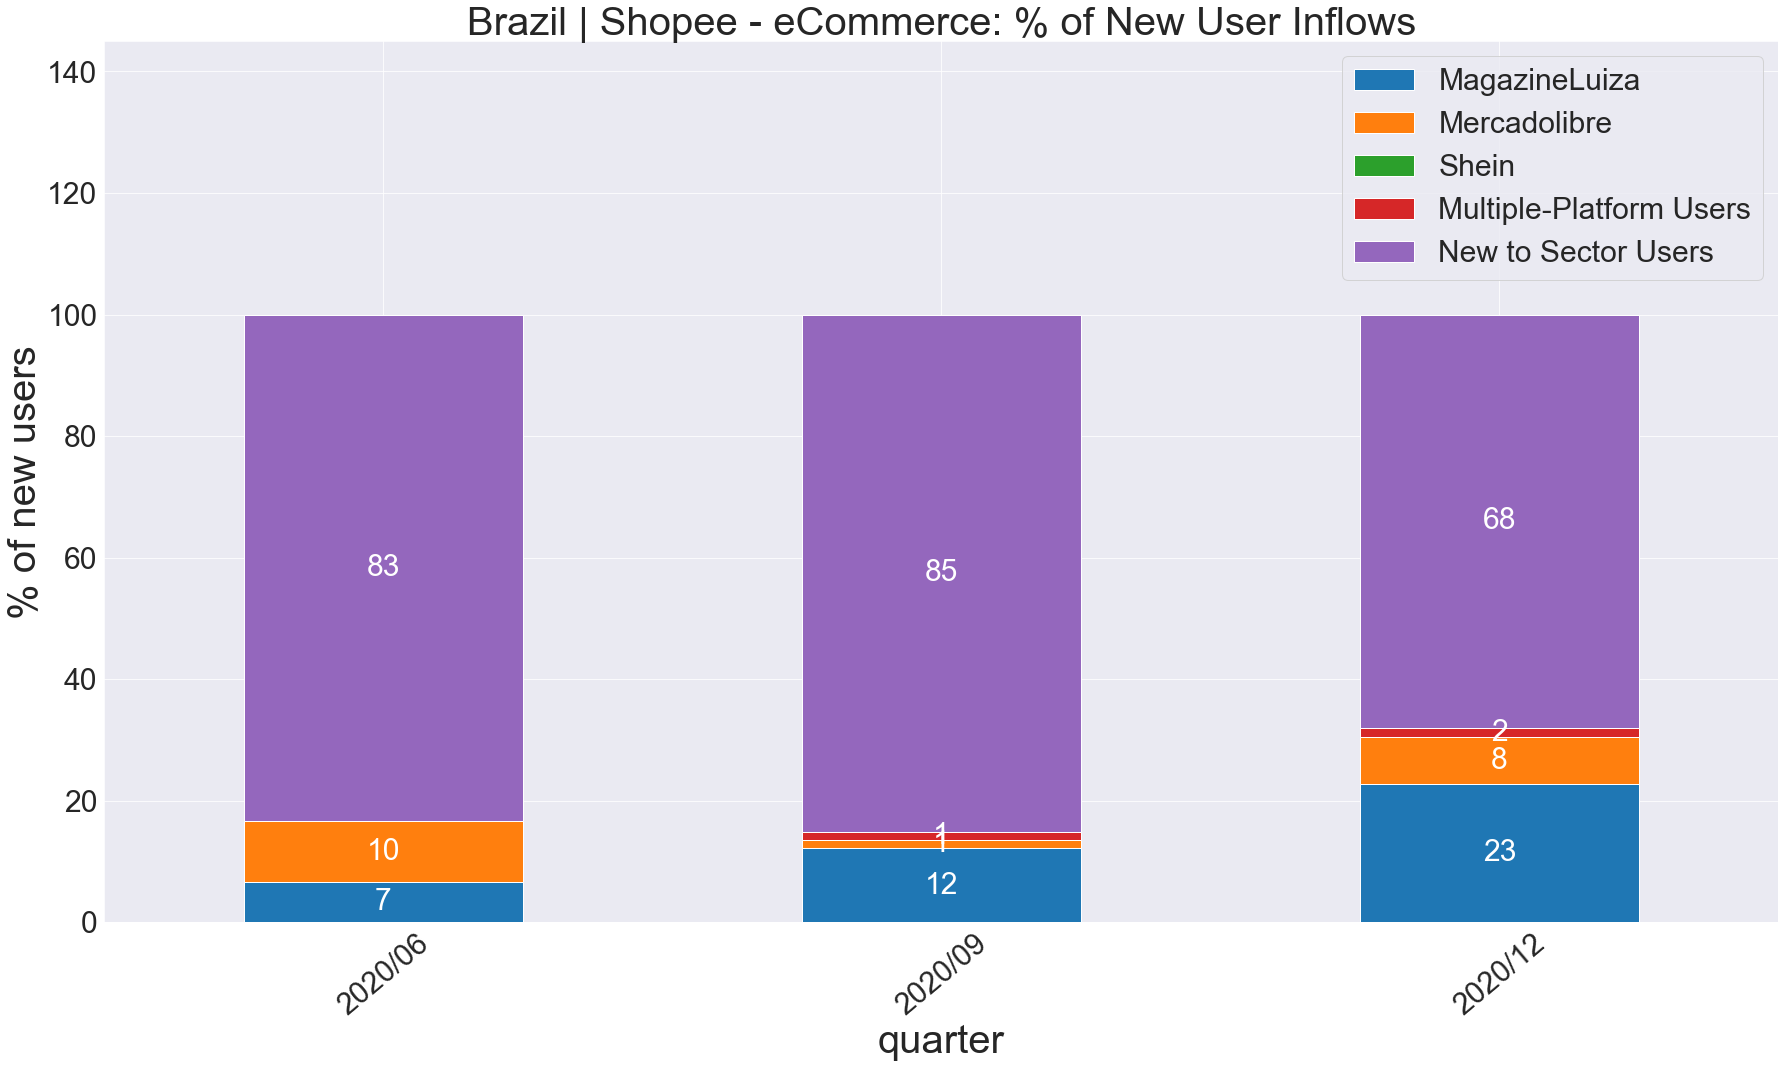

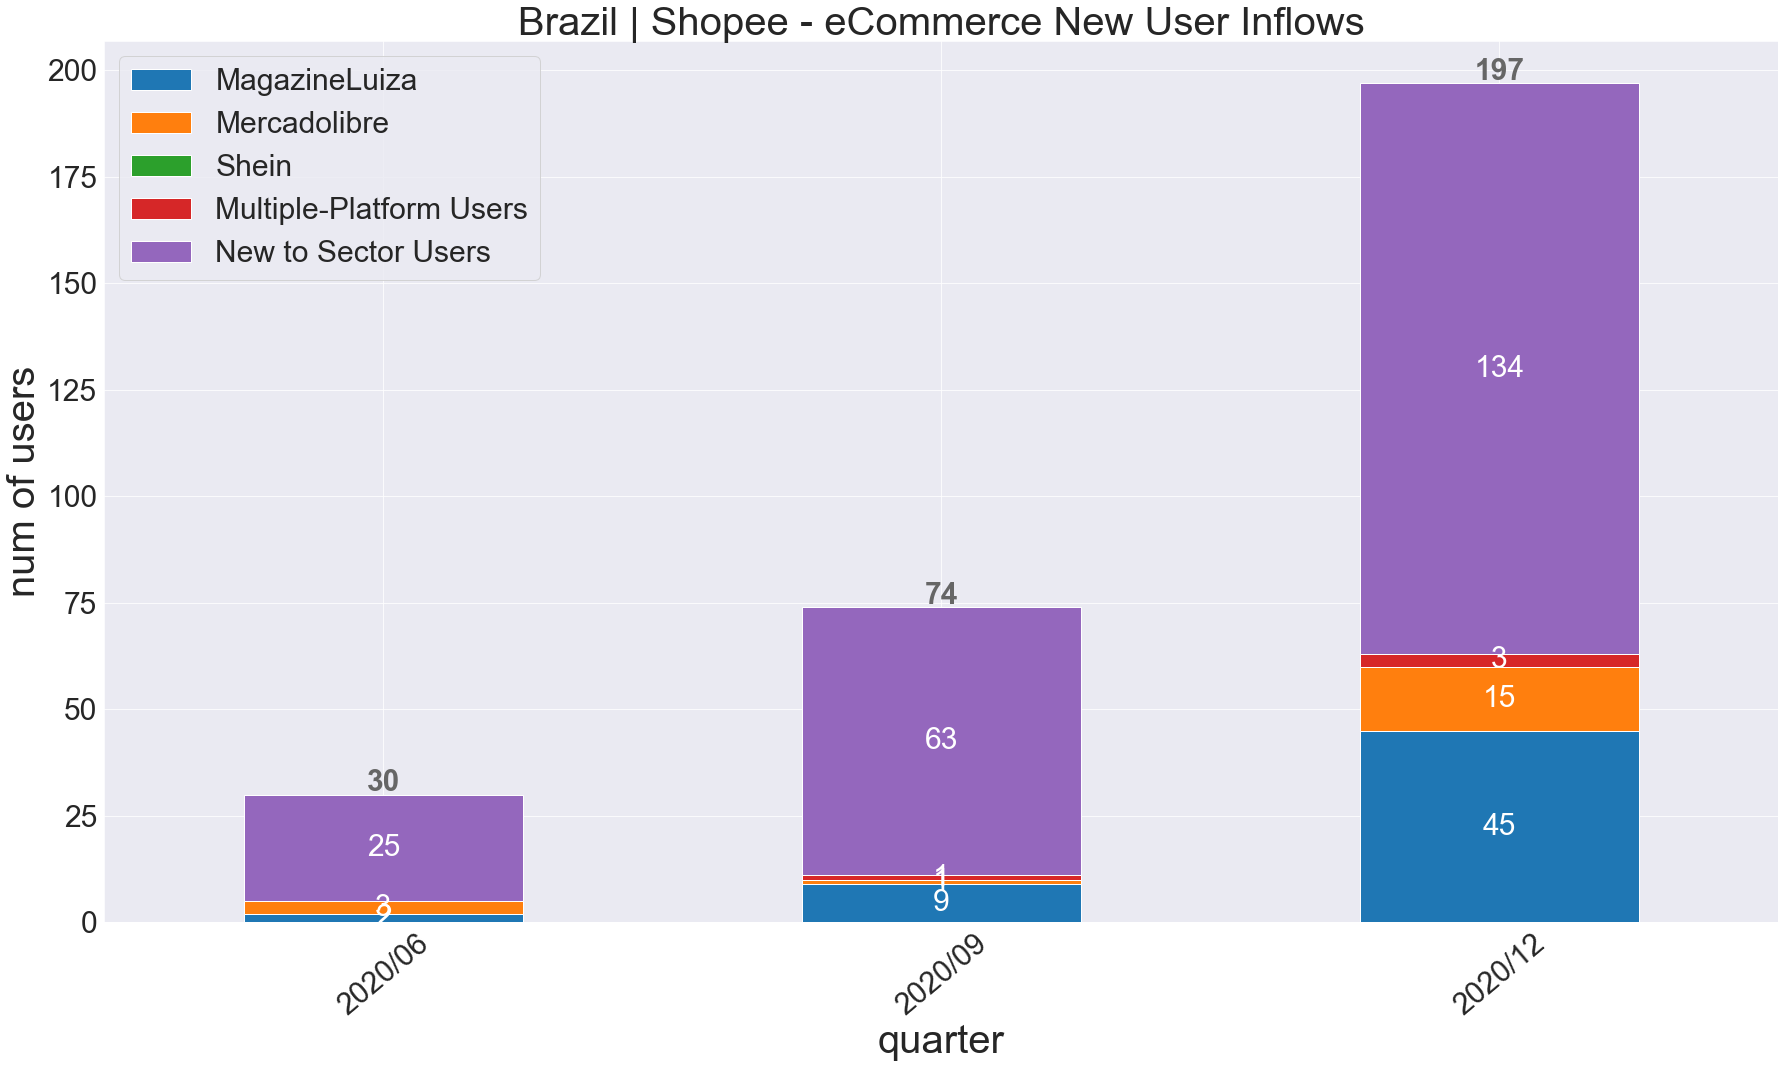

In [8]:
# new user inflows
sectors = ['eCommerce']
given_platform = 'Shopee'
country = 'Brazil'
platforms = None
freq ='Q'
pct_breakdown, absolute_val_breakdown = get_new_user_sources(given_platform, country, platforms=platforms, sectors=sectors, freq=freq)

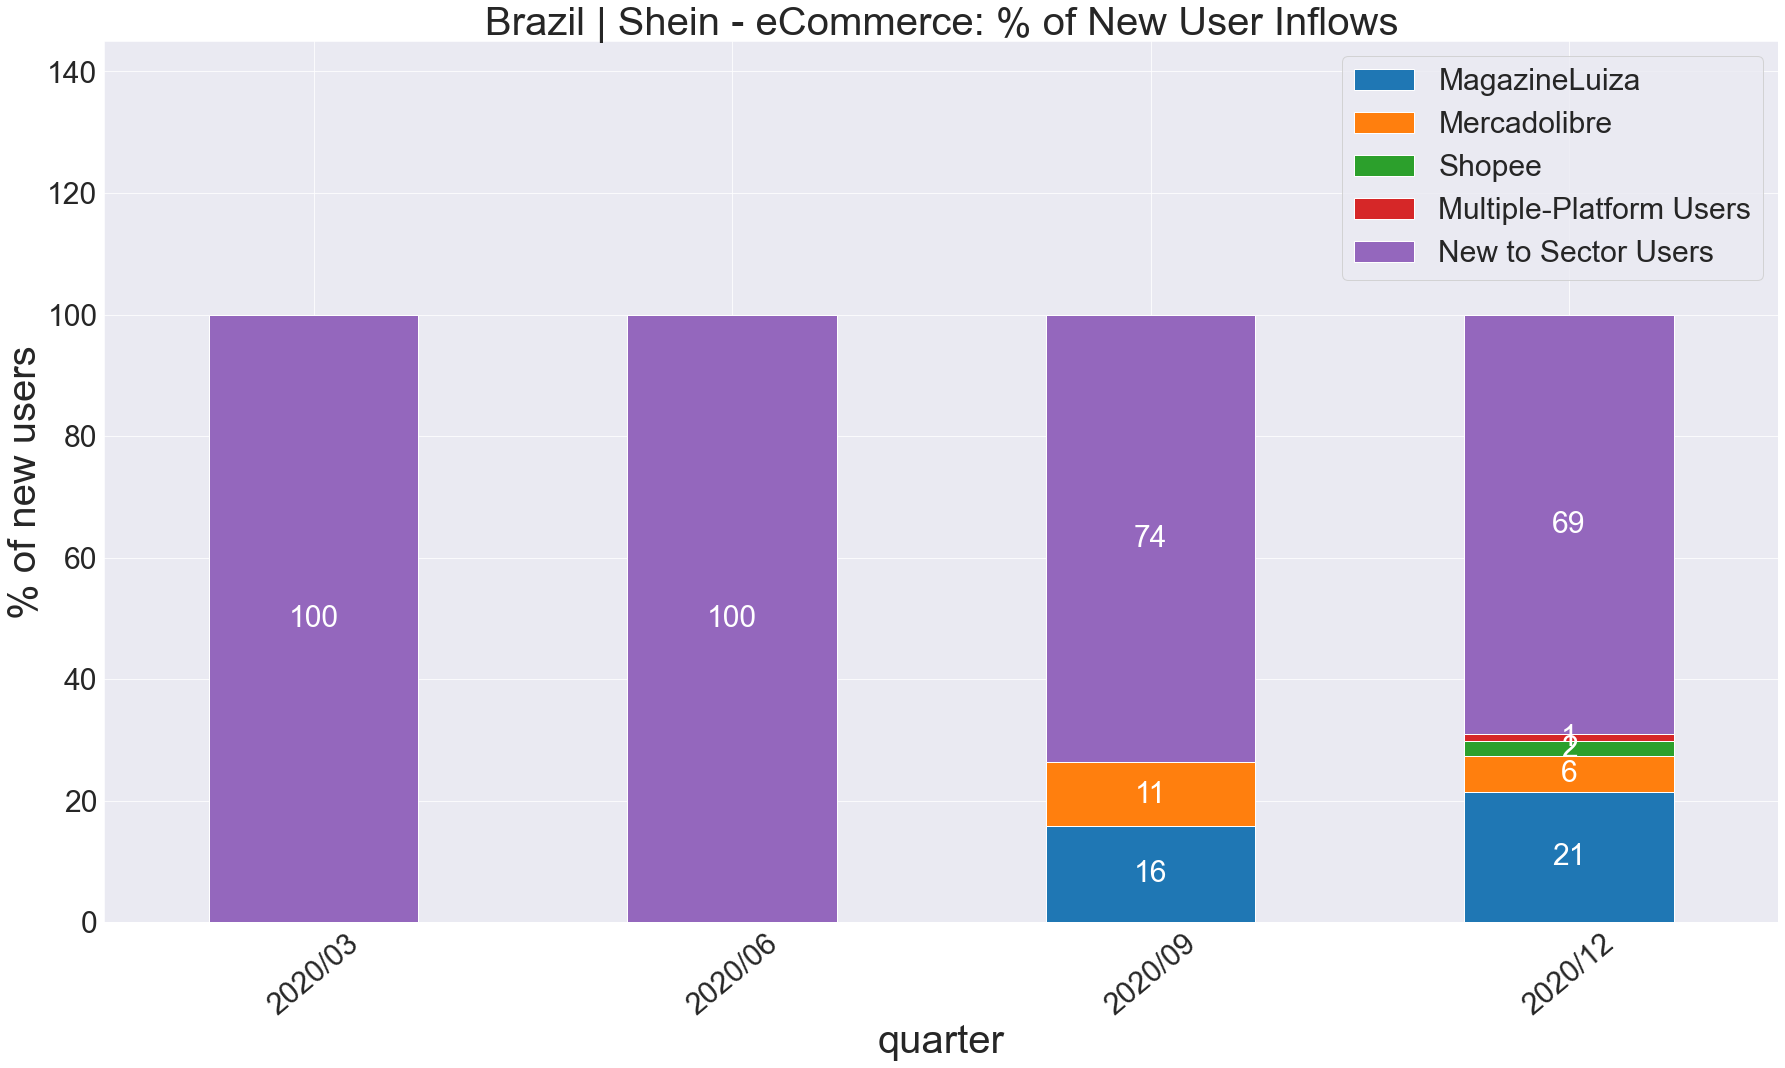

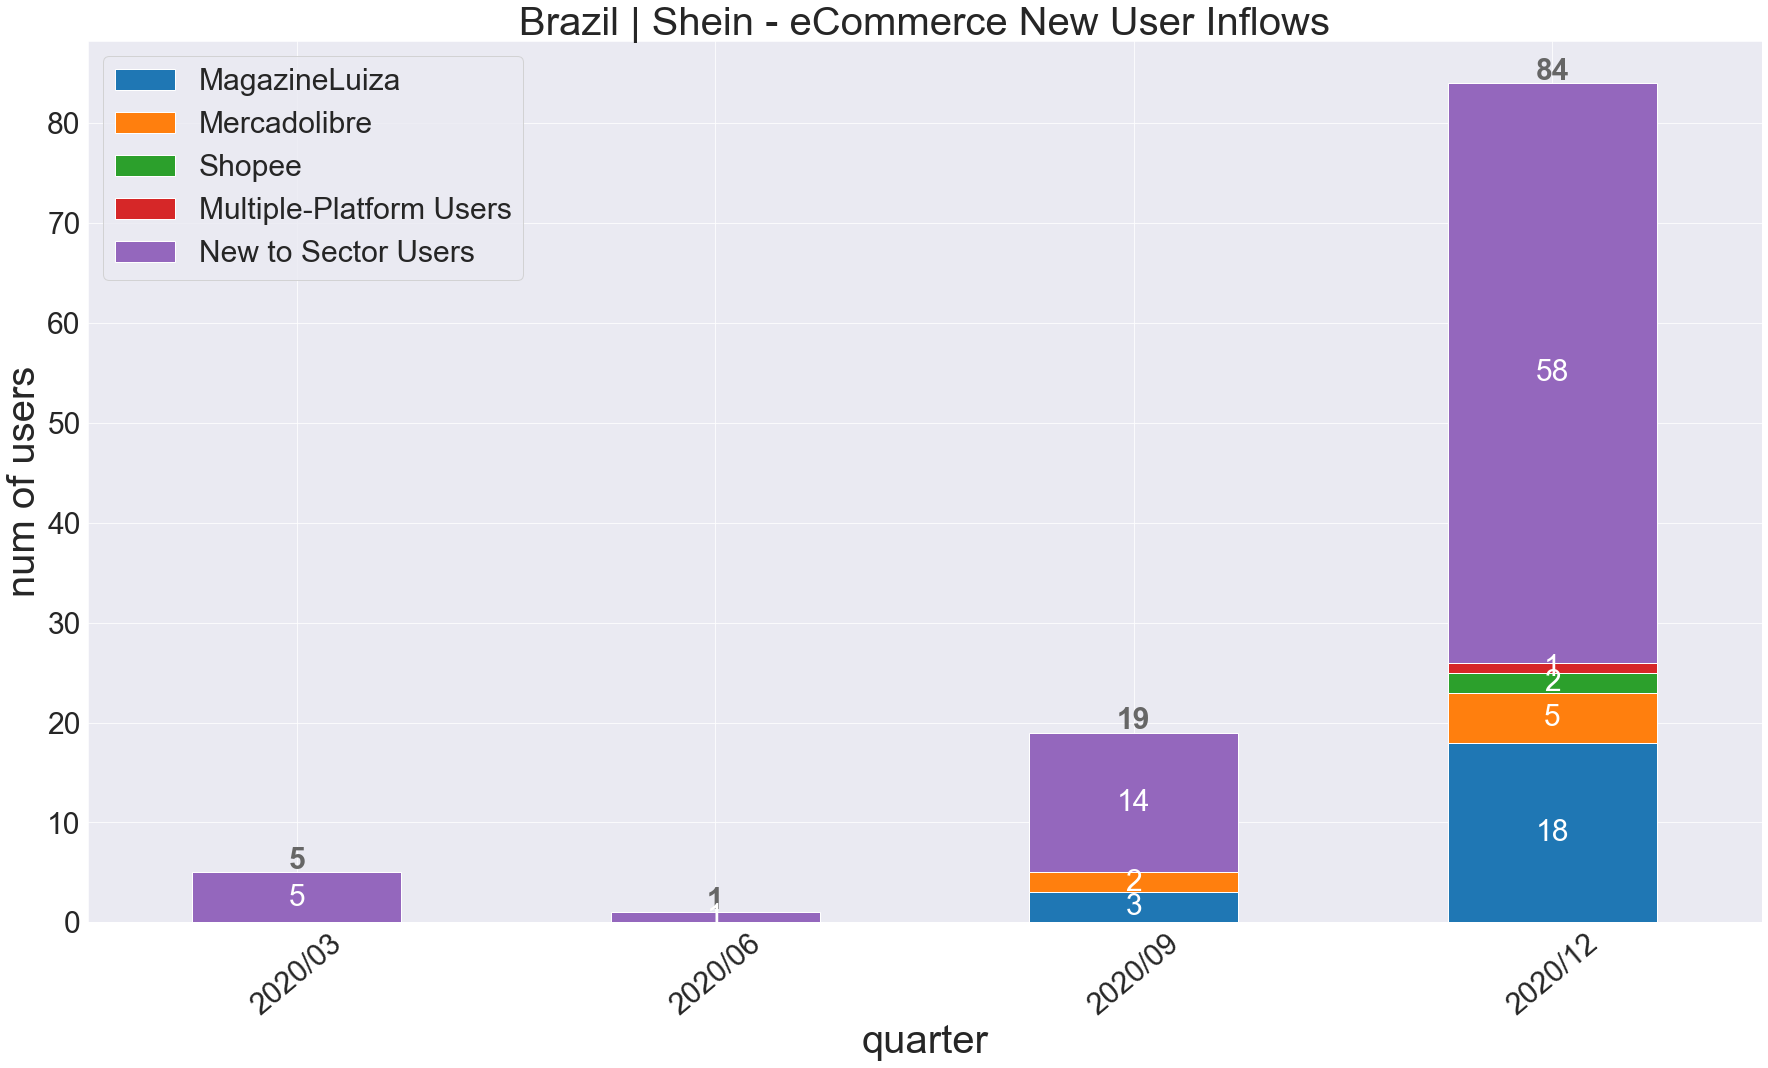

In [9]:
sectors = None
given_platform = 'Shein'
country = 'Brazil'
platforms = None
freq ='Q'
pct_breakdown, absolute_val_breakdown = get_new_user_sources(given_platform, country, platforms=platforms, sectors=sectors, freq=freq)

In [10]:
def get_time_series_of_user_basics(sector: str, country_list: list, group_by: str, chart_groupby, platforms=None,
                                   freq='M'):
    '''
    sector: str
        ['Ride Hailing', 'Food Delivery', 'eCommerce']
    country_list:
        list of country names
    platforms:
        platform list or None
        if platforms != None & group by = 'sector'
            -- will give a sector summary including only selected platform
    group_by:
        ['sector', 'platform']

    chart_groupby:
        ['platform', 'country']
    freq :
        ['M', 'Q']
    Returns

    Plot 5 charts respectively (1 sector/platform per chart
    1 dataframe for # of user, # of orders, GMV, orders per user, AOV(GMV/order #) grouped by country, month/quarter, sector/platform
    -------

    '''
    user_col = 'num_of_users'
    order_col = 'num_of_orders'
    gmv_col = 'GMV'
    order_per_user_col = 'num_of_orders_per_user'
    aov_col = 'AOV'

    # if platforms is not None:
    #     if (len(platforms)>1) & (split_countries is True) & group_by=='platform':
    #         multiple_charts_by_platform = True
    # raise ValueError('if group by platform when selecting >1 platforms, can not split countries')
    df = get_raw_data(sector, platforms, country_list)
    df.set_index(DATE_COL, inplace=True)
    df.index = pd.to_datetime(df.index)
    output_date_col = DATE_COL_DICT[freq]

    groupby_keys = list(set([group_by, chart_groupby]))

    def get_basic_metrics(group):
        return pd.Series({user_col: group[USER_ID].nunique(),
                          order_col: group[ORDER_ID].nunique(),
                          gmv_col: group[GMV_COL].sum()
                          })

    df_ = df.groupby(groupby_keys).resample(freq)[[USER_ID, ORDER_ID, GMV_COL]].apply(
        lambda g: get_basic_metrics(g)).reset_index()

    value_columns = [user_col, order_col, gmv_col]
    min_date = df_[DATE_COL].min()
    max_date = df_[DATE_COL].max()
    full_date_range = pd.date_range(min_date, max_date, freq=freq)
    df_ = pd.pivot_table(df_,
                         values=value_columns,
                         index=DATE_COL,
                         columns=groupby_keys,
                         fill_value=0)
    df_ = df_.reindex(full_date_range)
    stack_columns_index = list(range(1, len(groupby_keys) + 1))
    df_ = df_.stack(stack_columns_index).reset_index().rename(columns={'level_0': output_date_col})
    df_[order_per_user_col] = df_[order_col] / df_[user_col].replace(0, np.nan)
    df_[aov_col] = df_[gmv_col] / df_[order_col].replace(0, np.nan)

    print(df_.platform.unique())

    date_col = output_date_col
    # num of users
    title = f'{sector}: # of Users '
    plot_series_1_chart(df_, date_col, user_col, chart_groupby, title, user_col, x_label=date_col, lengend_loc='best')

    # num of orders
    title = f'{sector}: # of Orders '
    plot_series_1_chart(df_, date_col, order_col, chart_groupby, title, order_col, x_label=date_col, lengend_loc='best')

    # GMV
    title = f'{sector}: GMV (US$) '
    plot_series_1_chart(df_, date_col, gmv_col, chart_groupby, title, gmv_col, x_label=date_col, lengend_loc='best')

    # orders per user
    title = f'{sector}: # of Orders per User (US$) '
    plot_series_1_chart(df_, date_col, order_per_user_col, chart_groupby, title, order_per_user_col, x_label=date_col,
                        lengend_loc='best')

    # AOV
    title = f'{sector}: AOV (US$) '
    plot_series_1_chart(df_, date_col, aov_col, chart_groupby, title, aov_col, x_label=date_col, lengend_loc='best')

    return df_

['Grab']


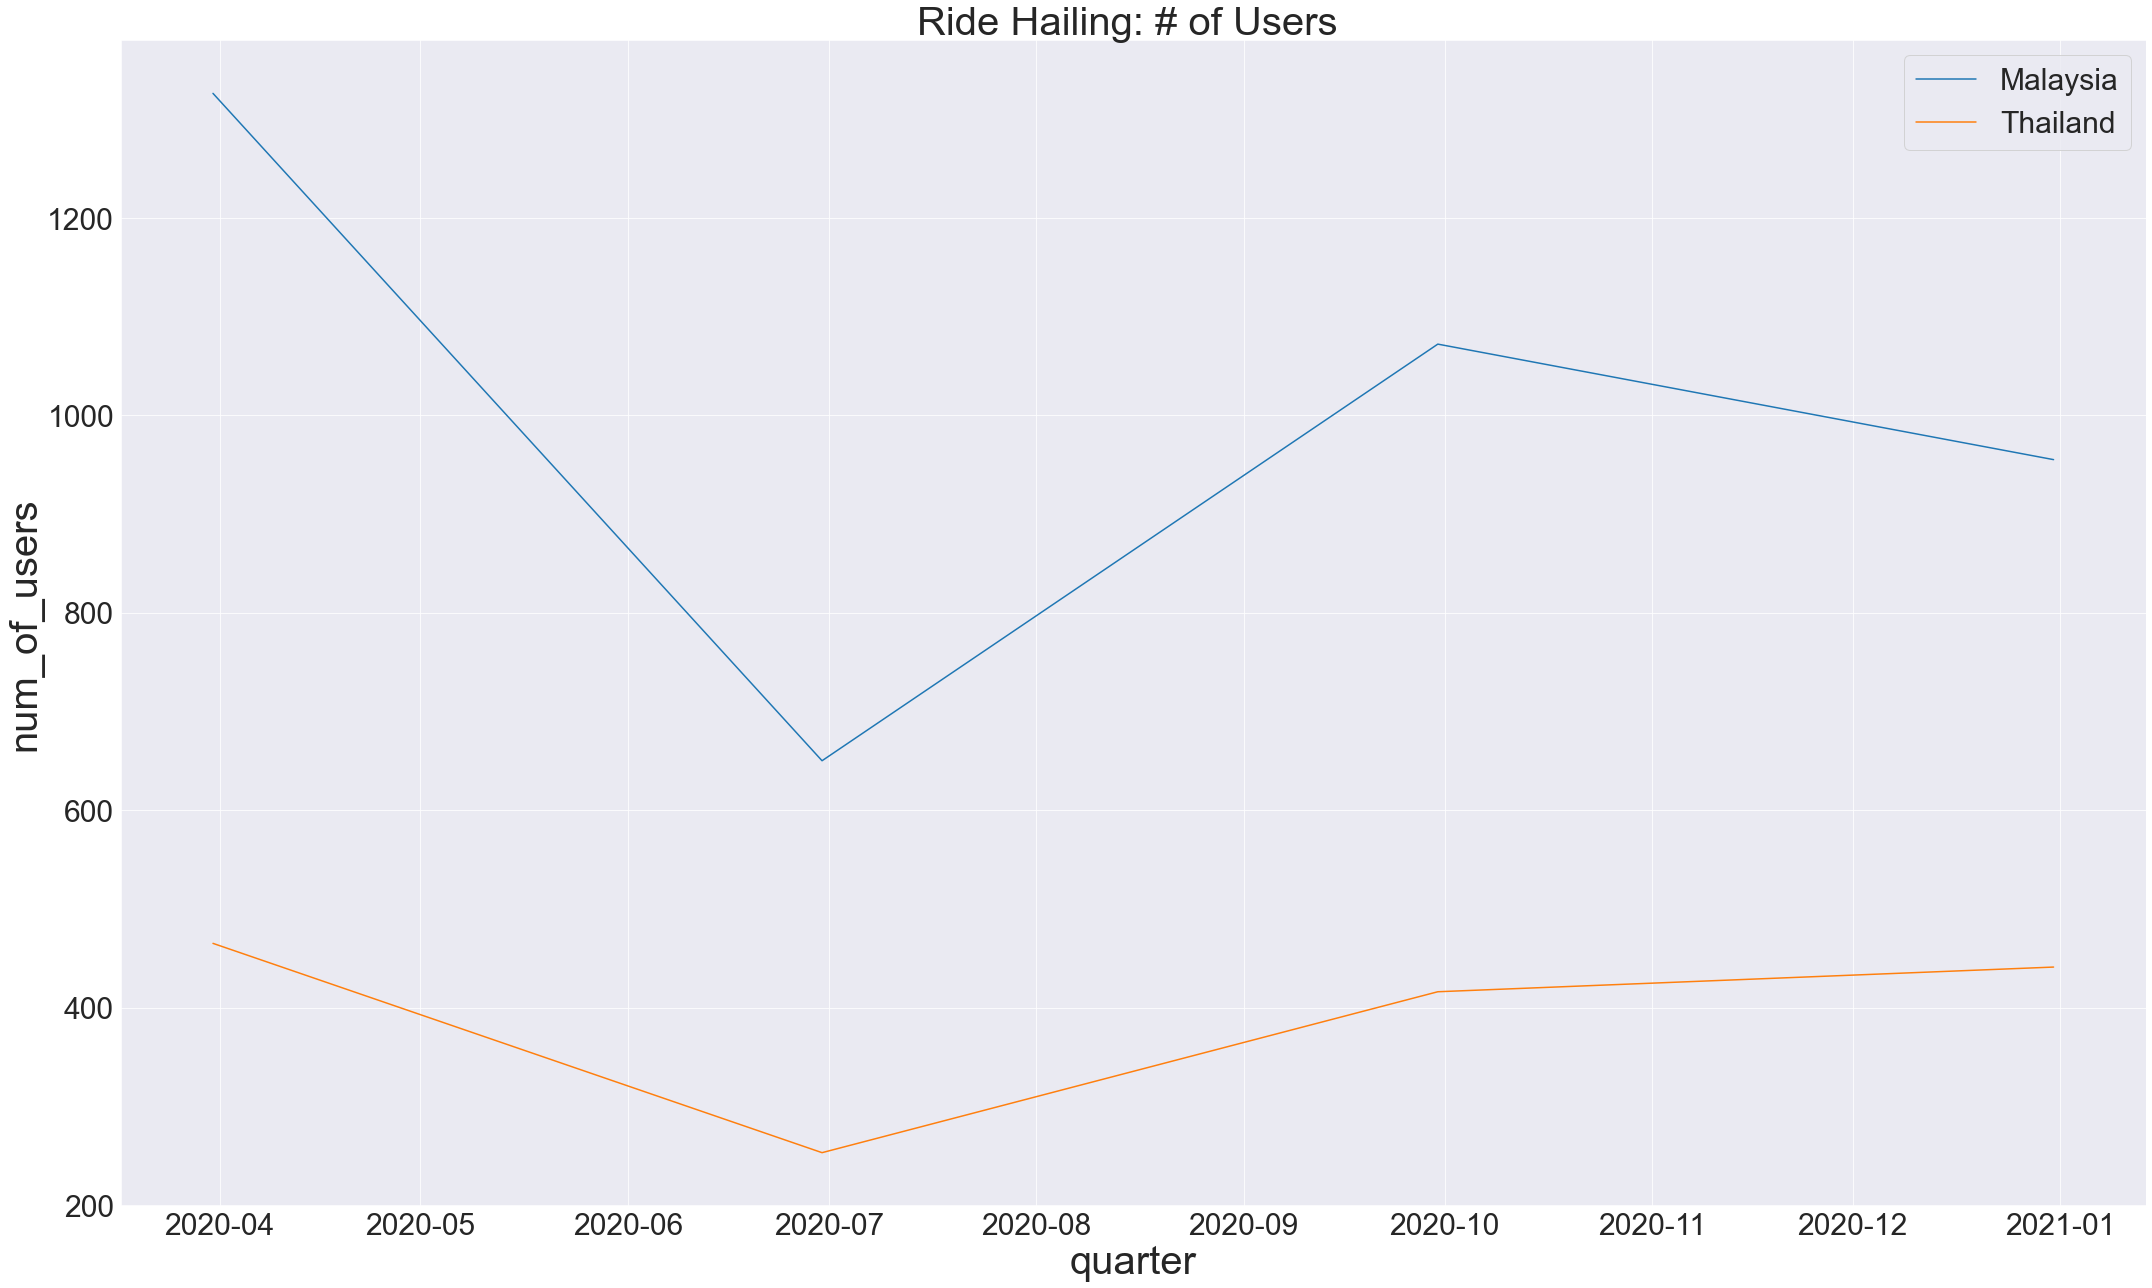

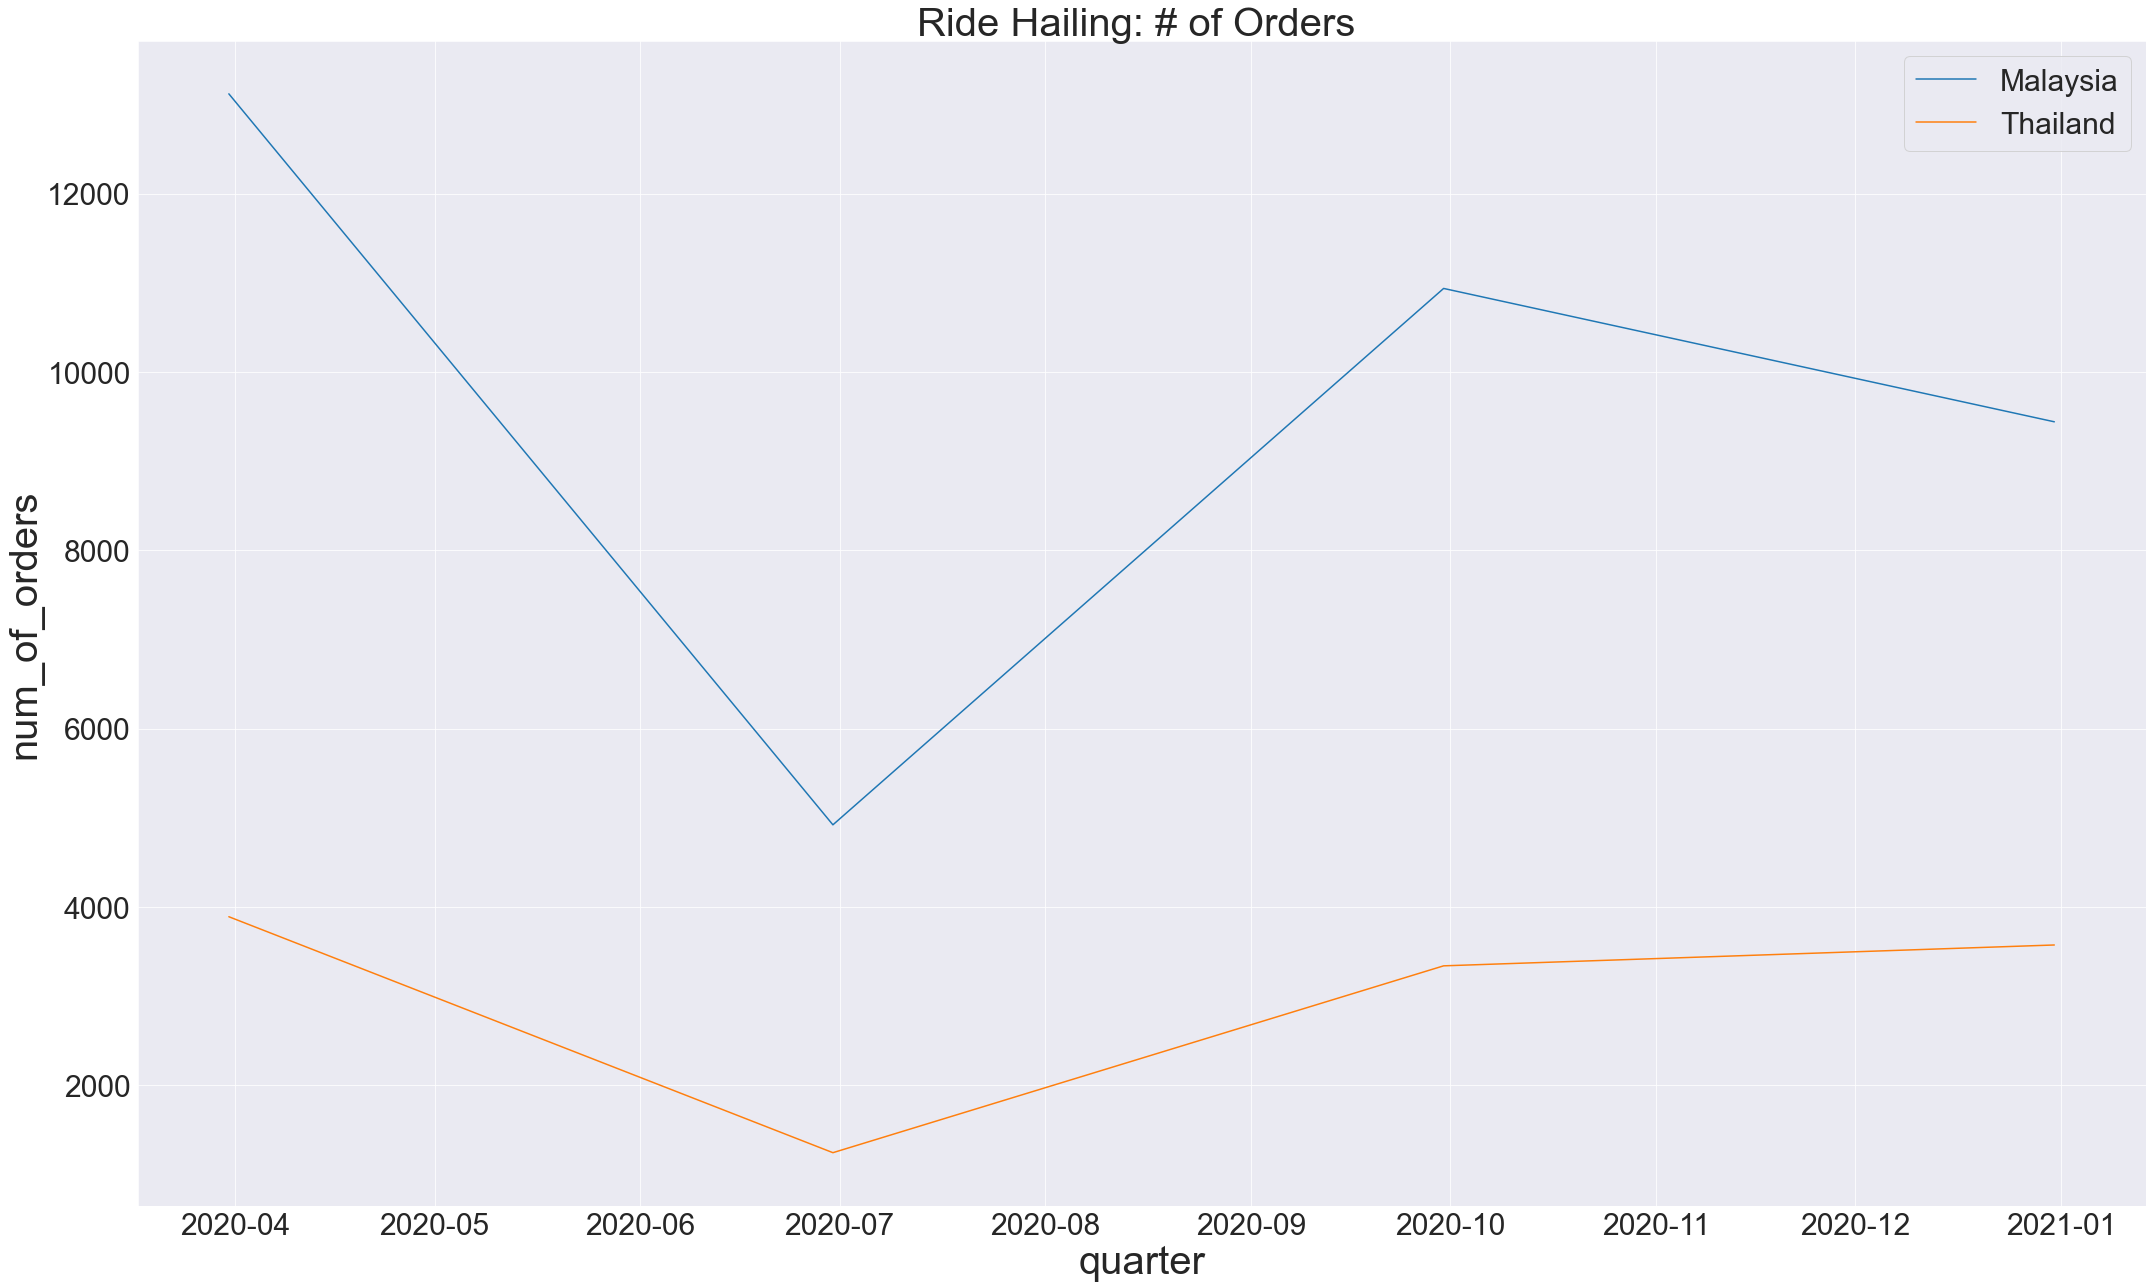

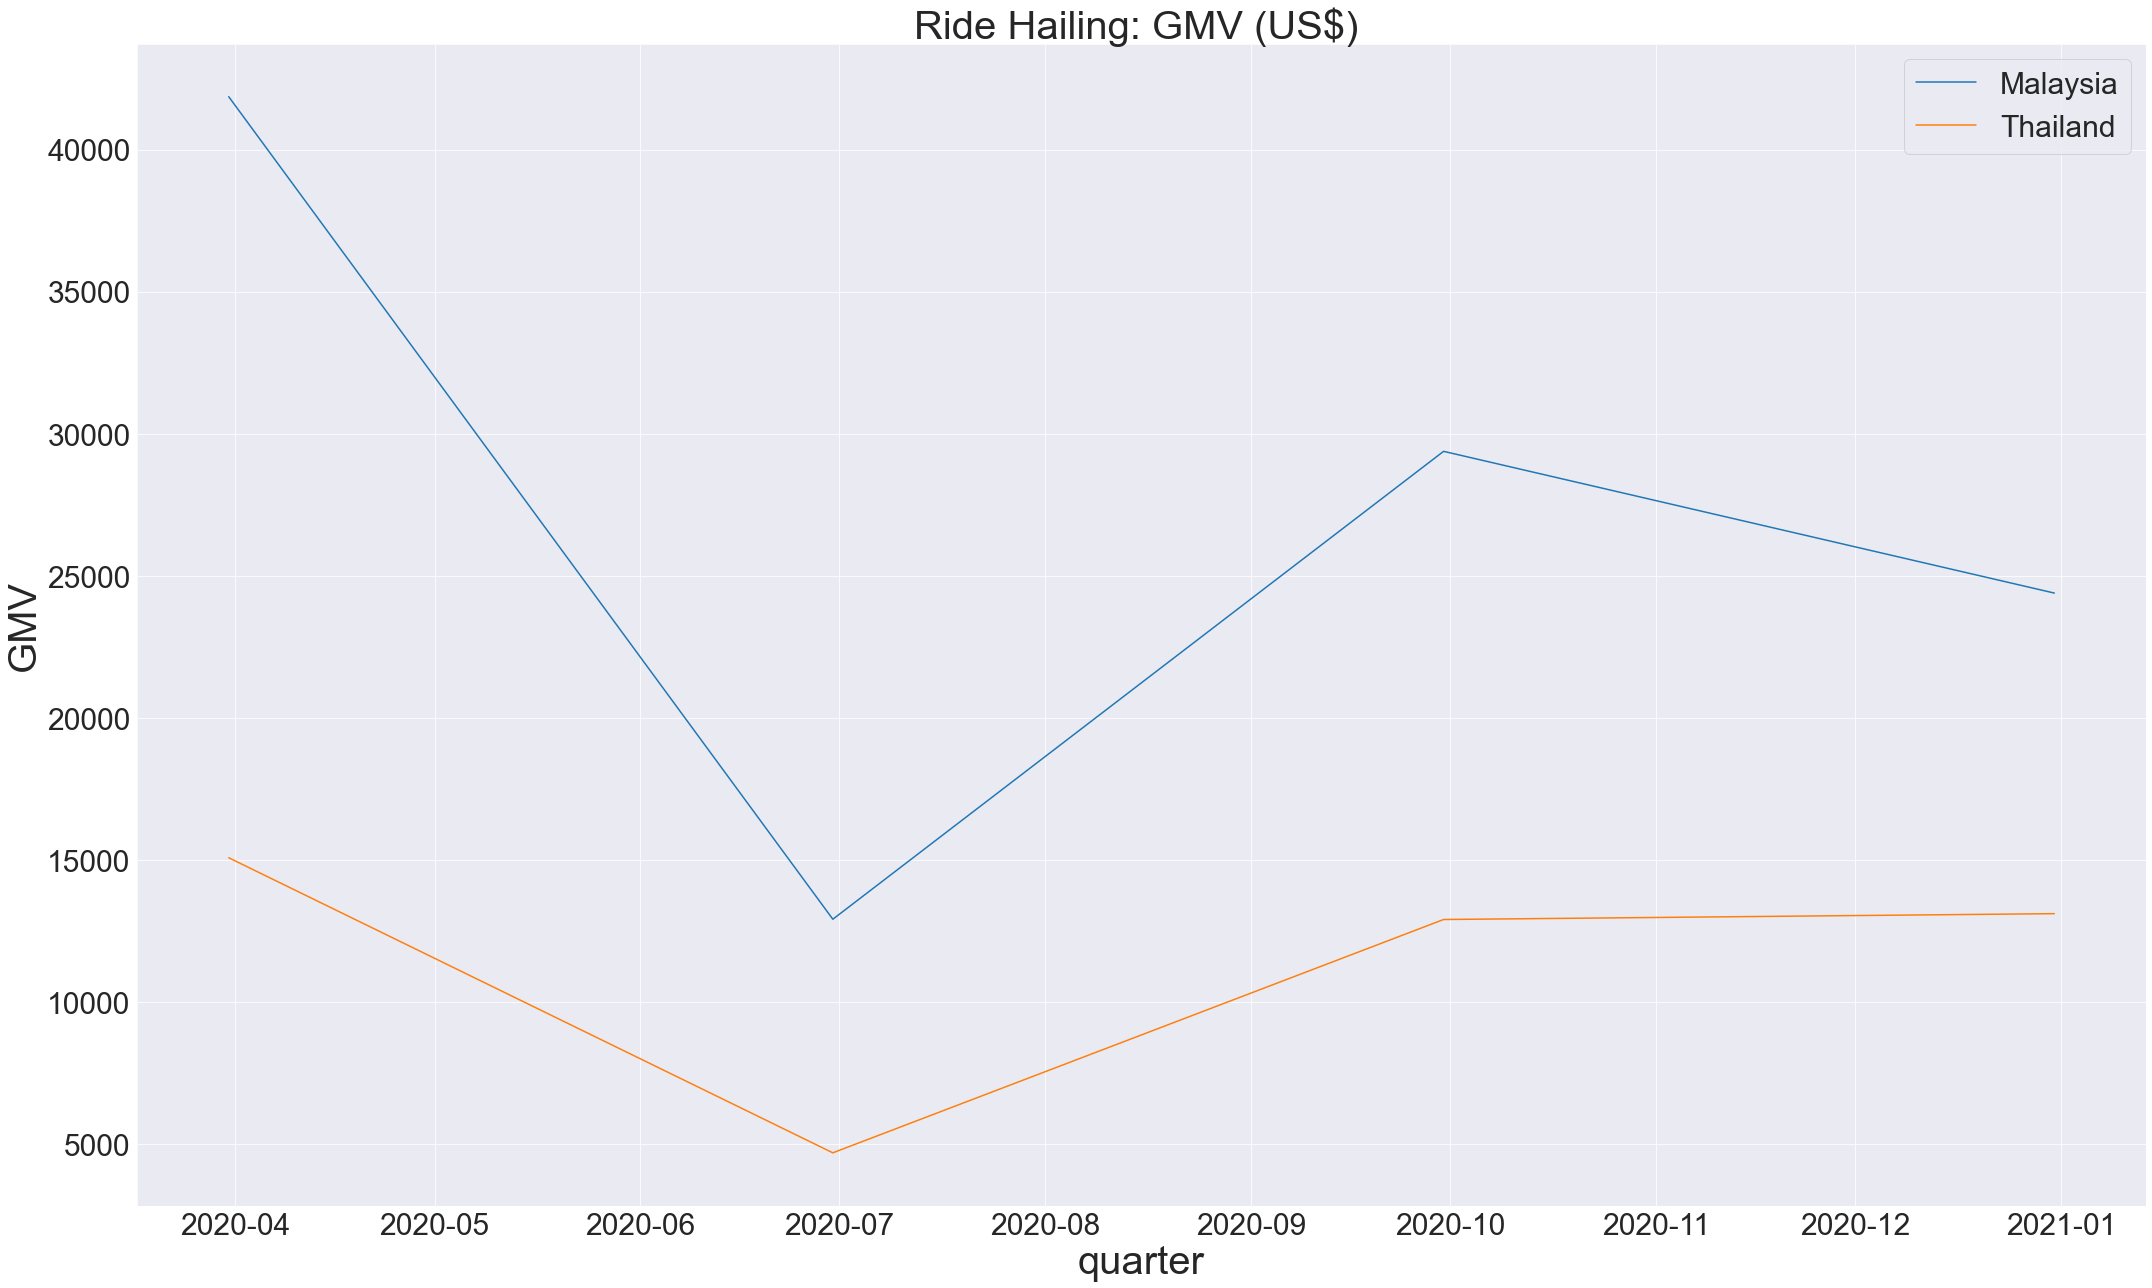

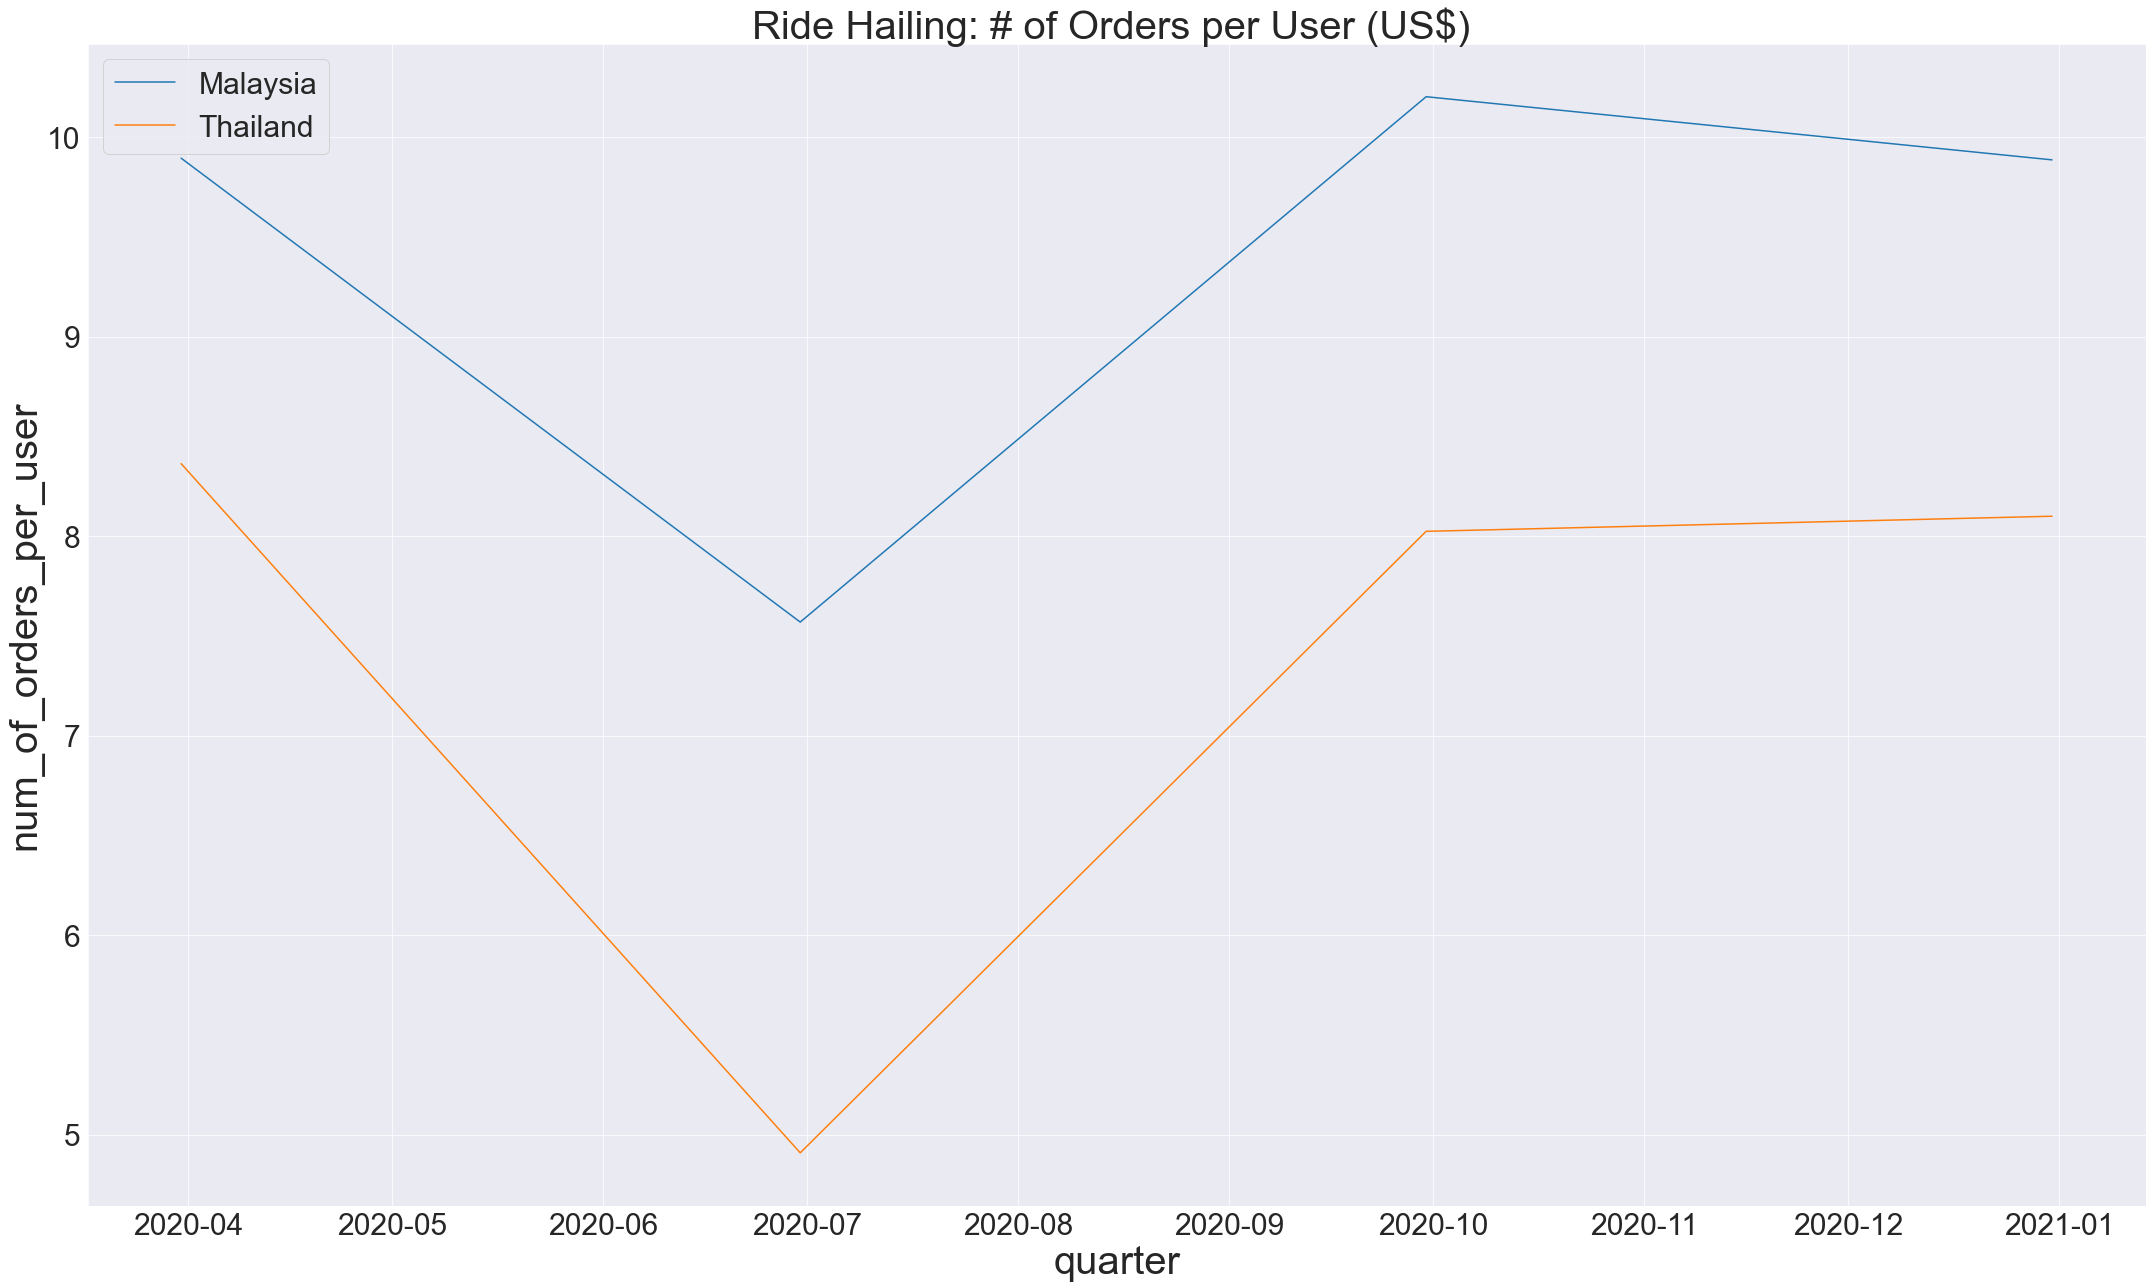

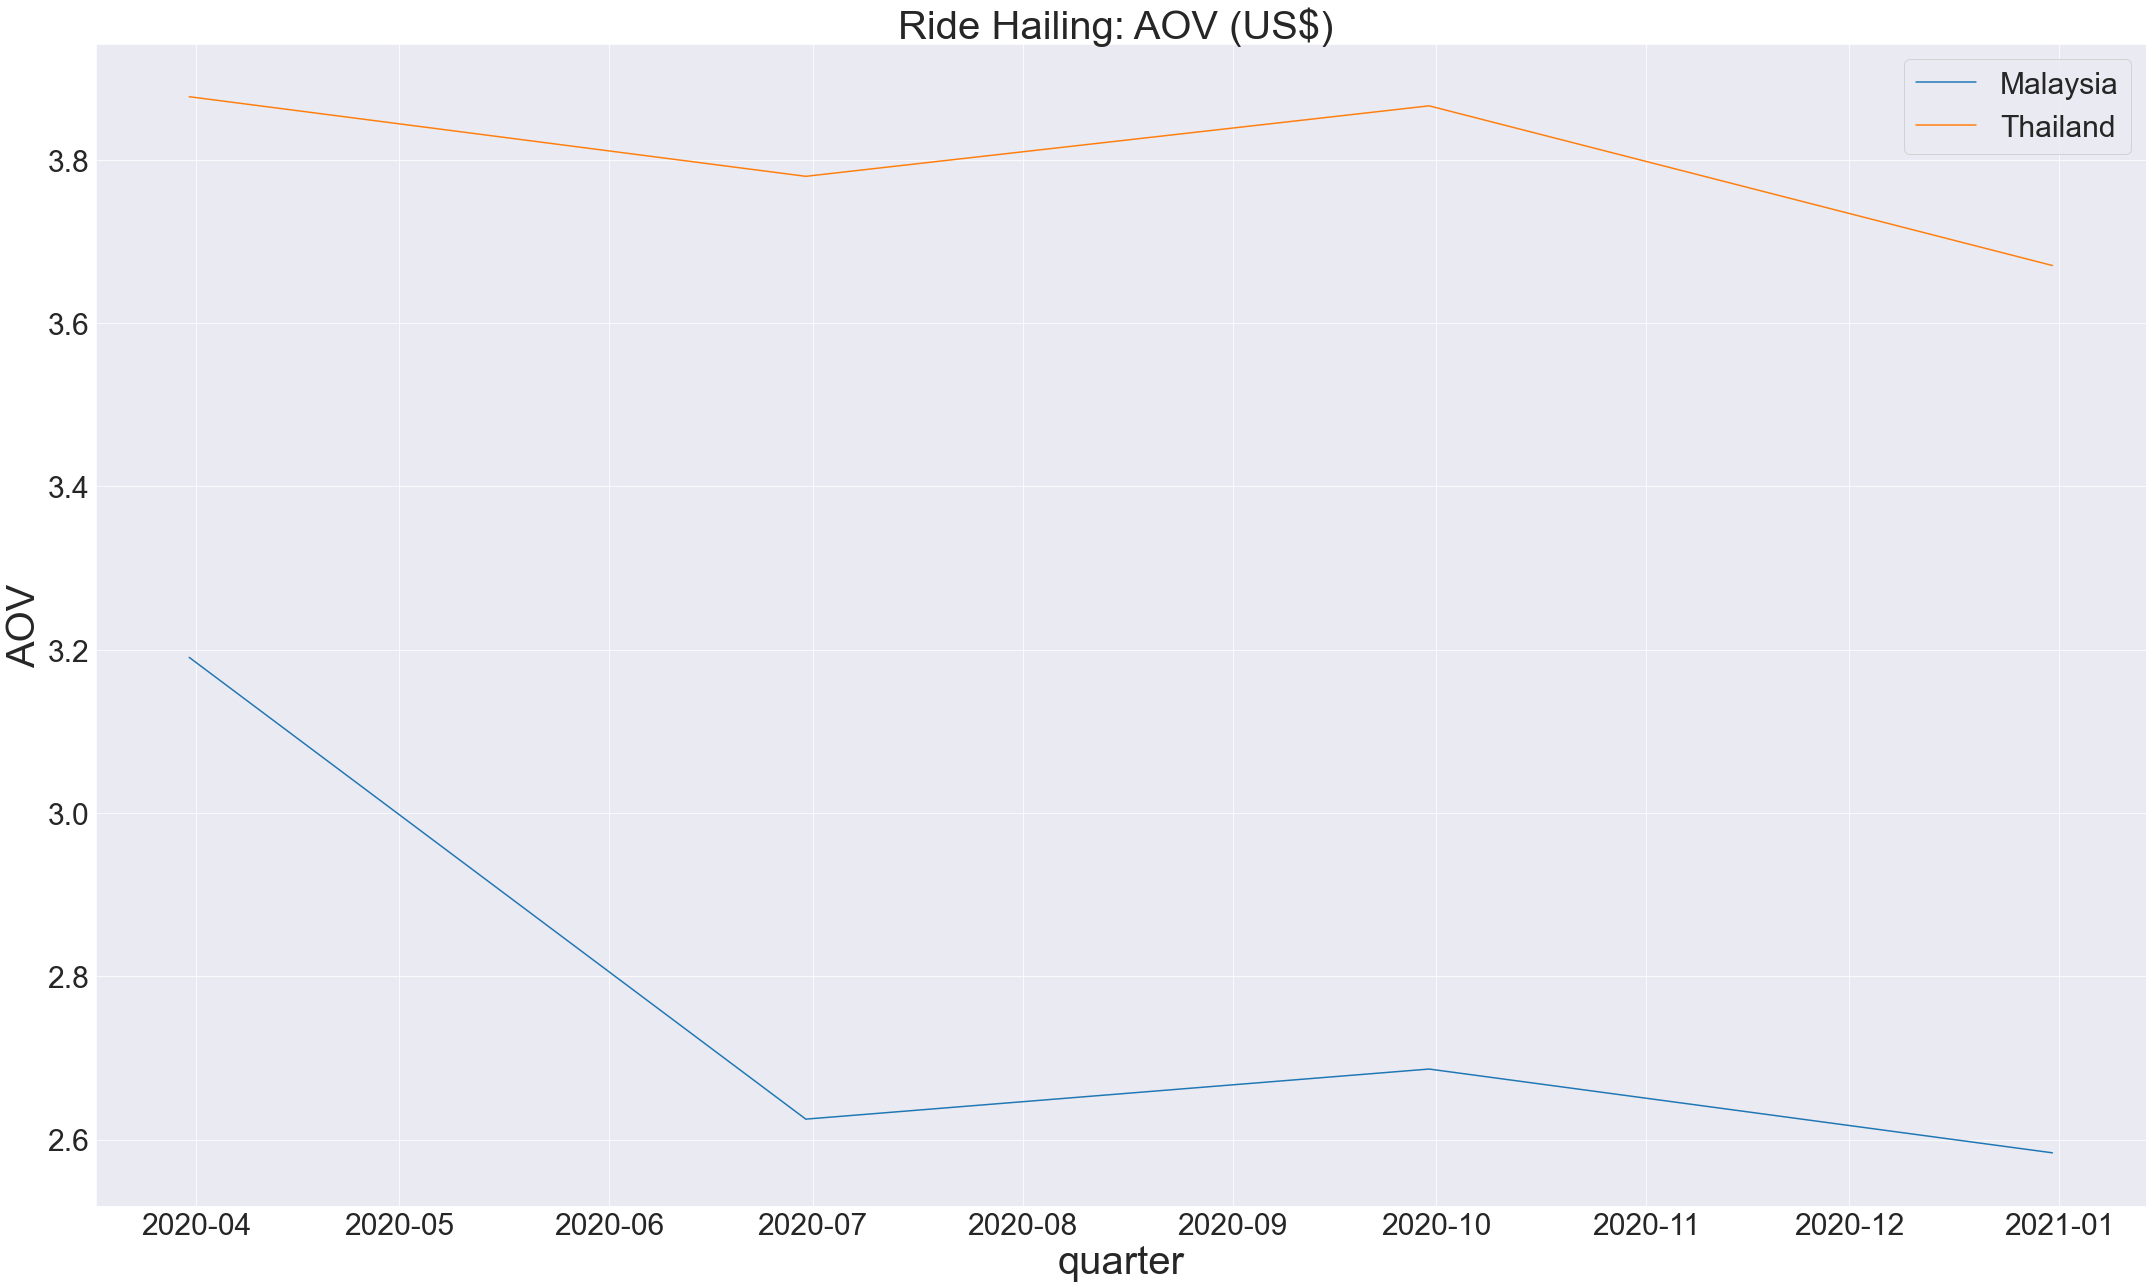

['GoJek' 'Grab']


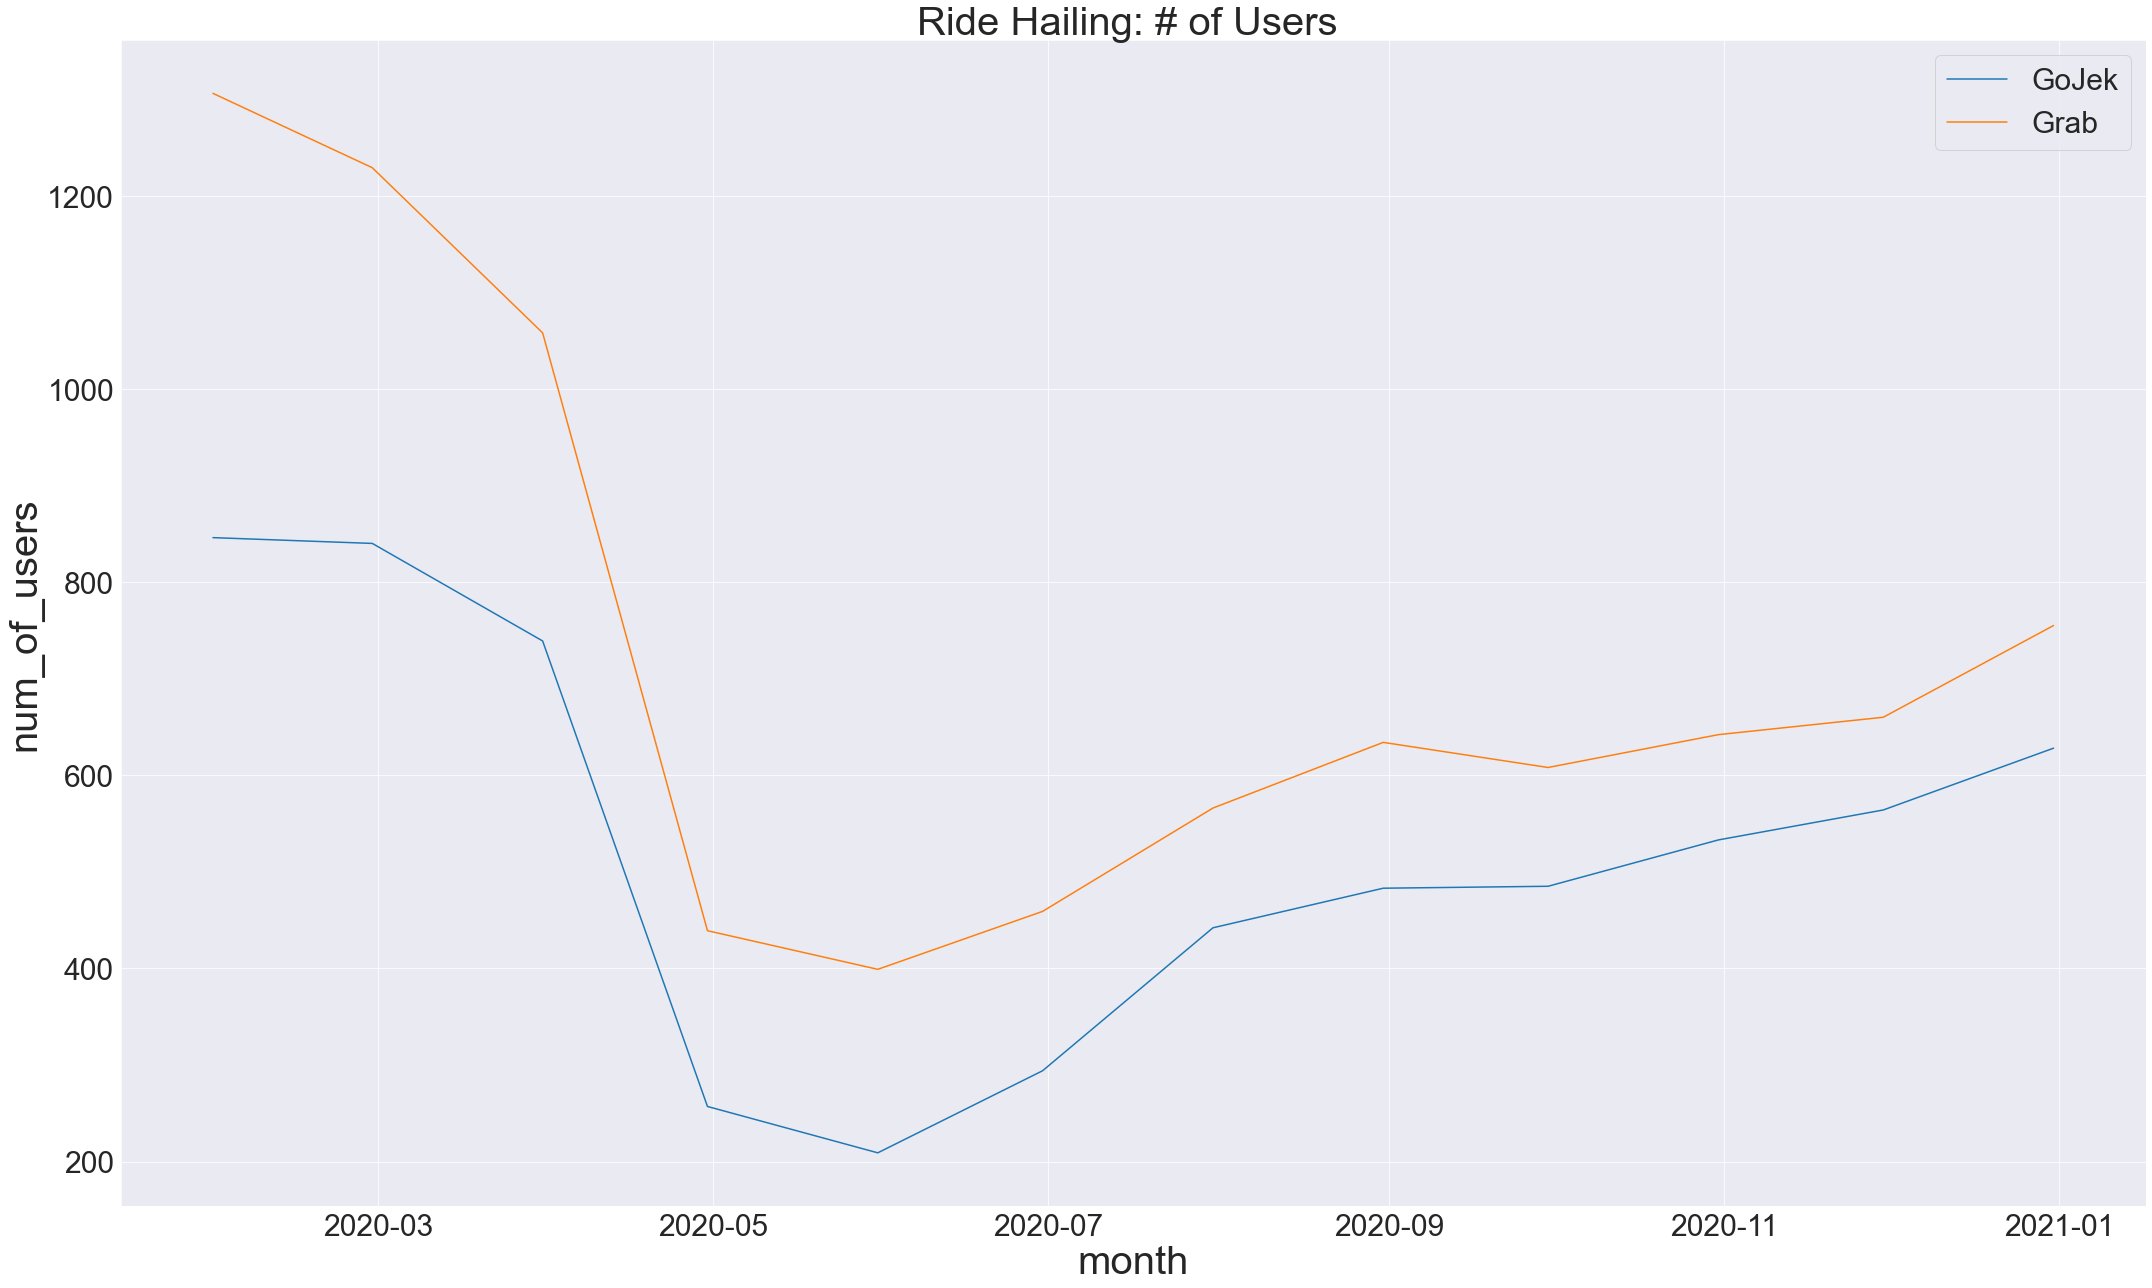

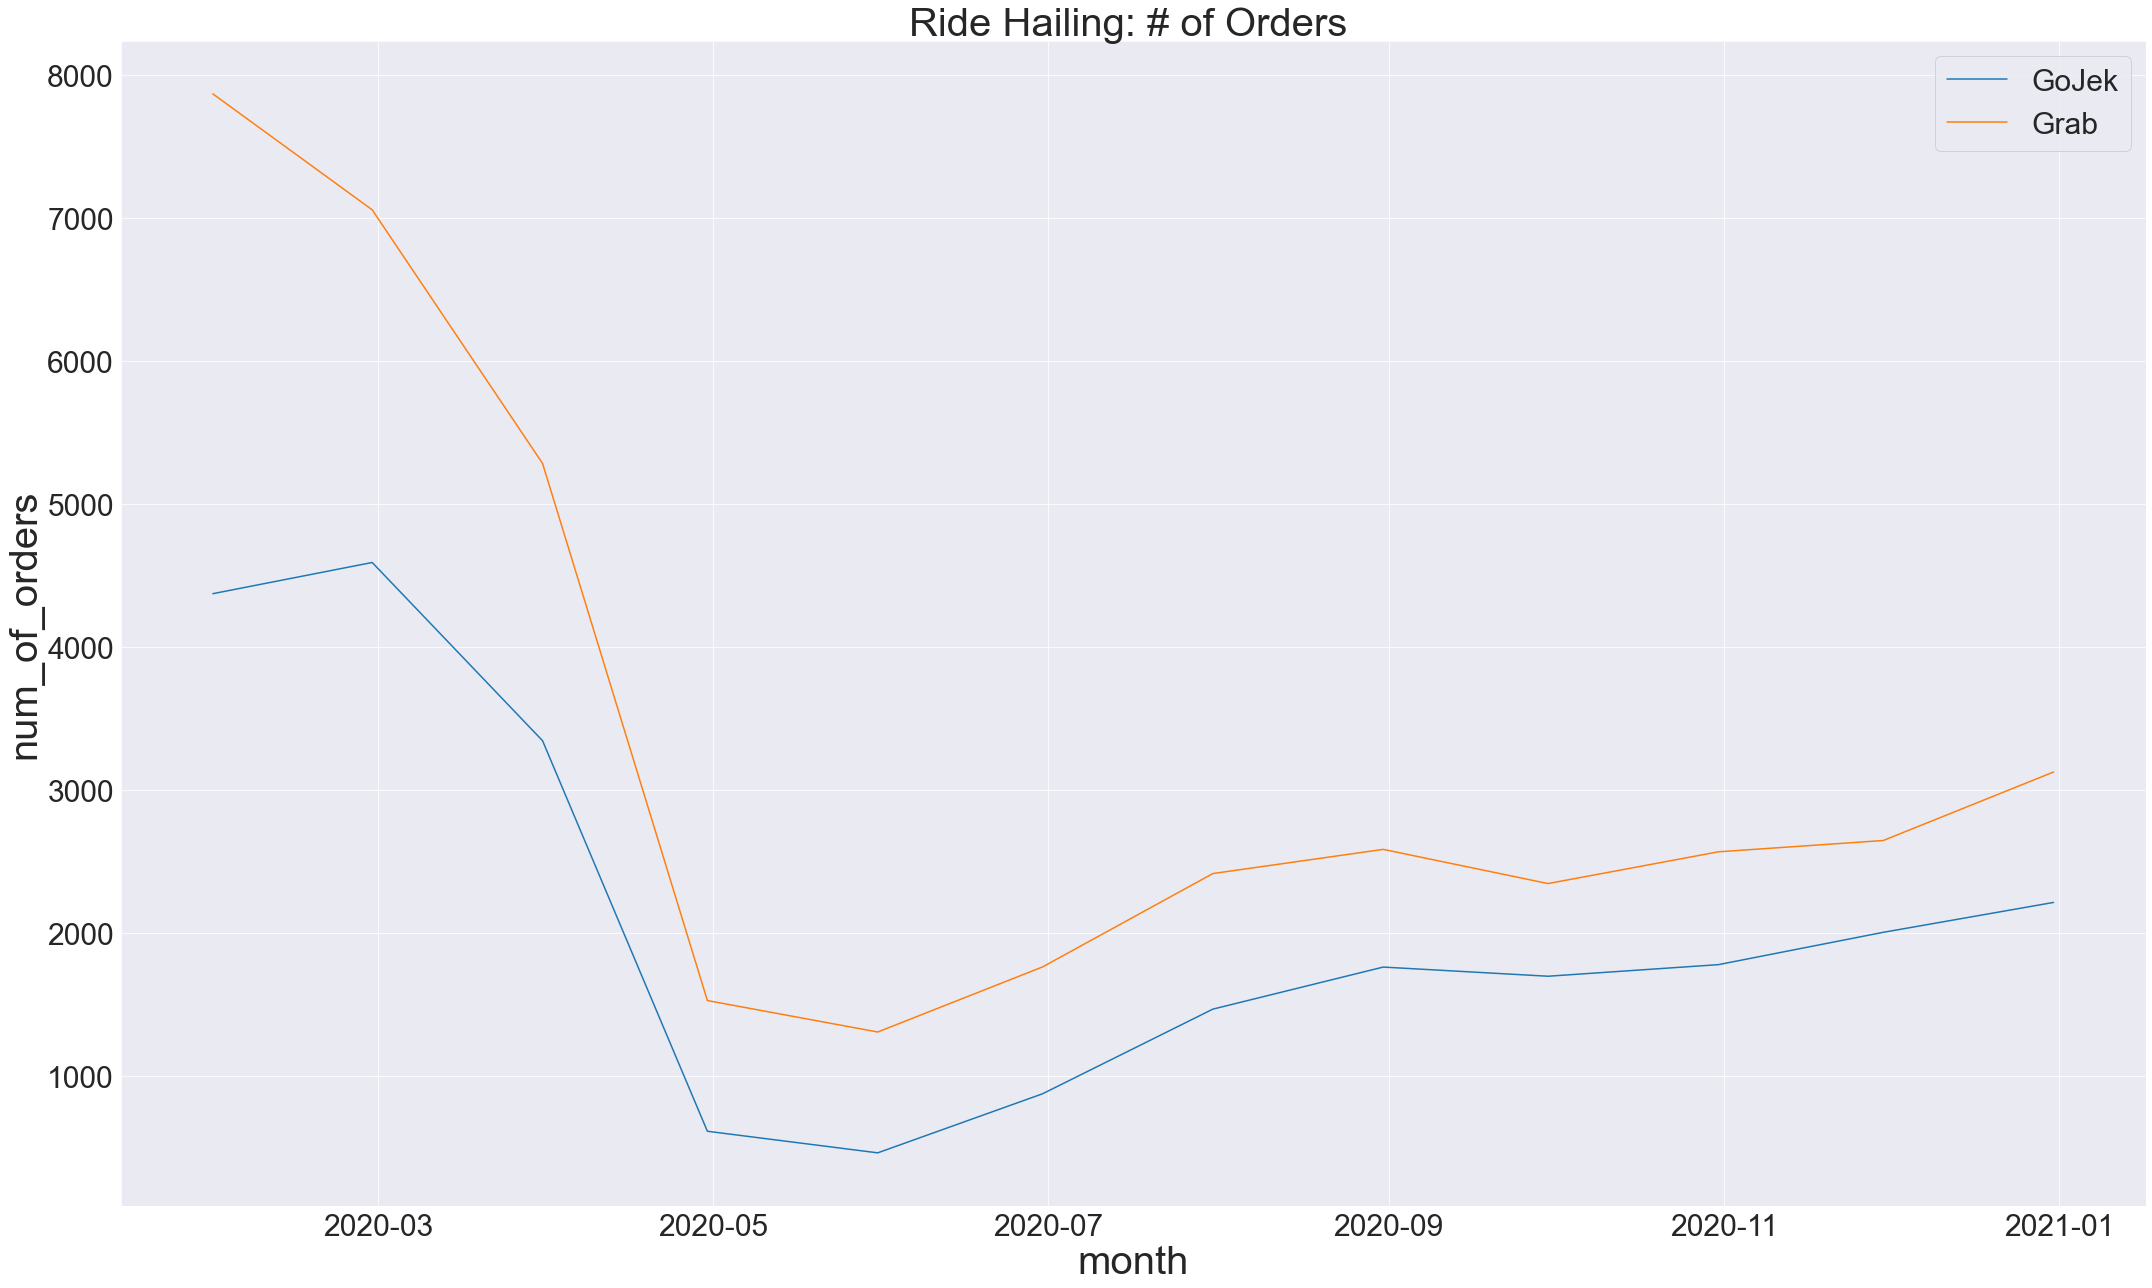

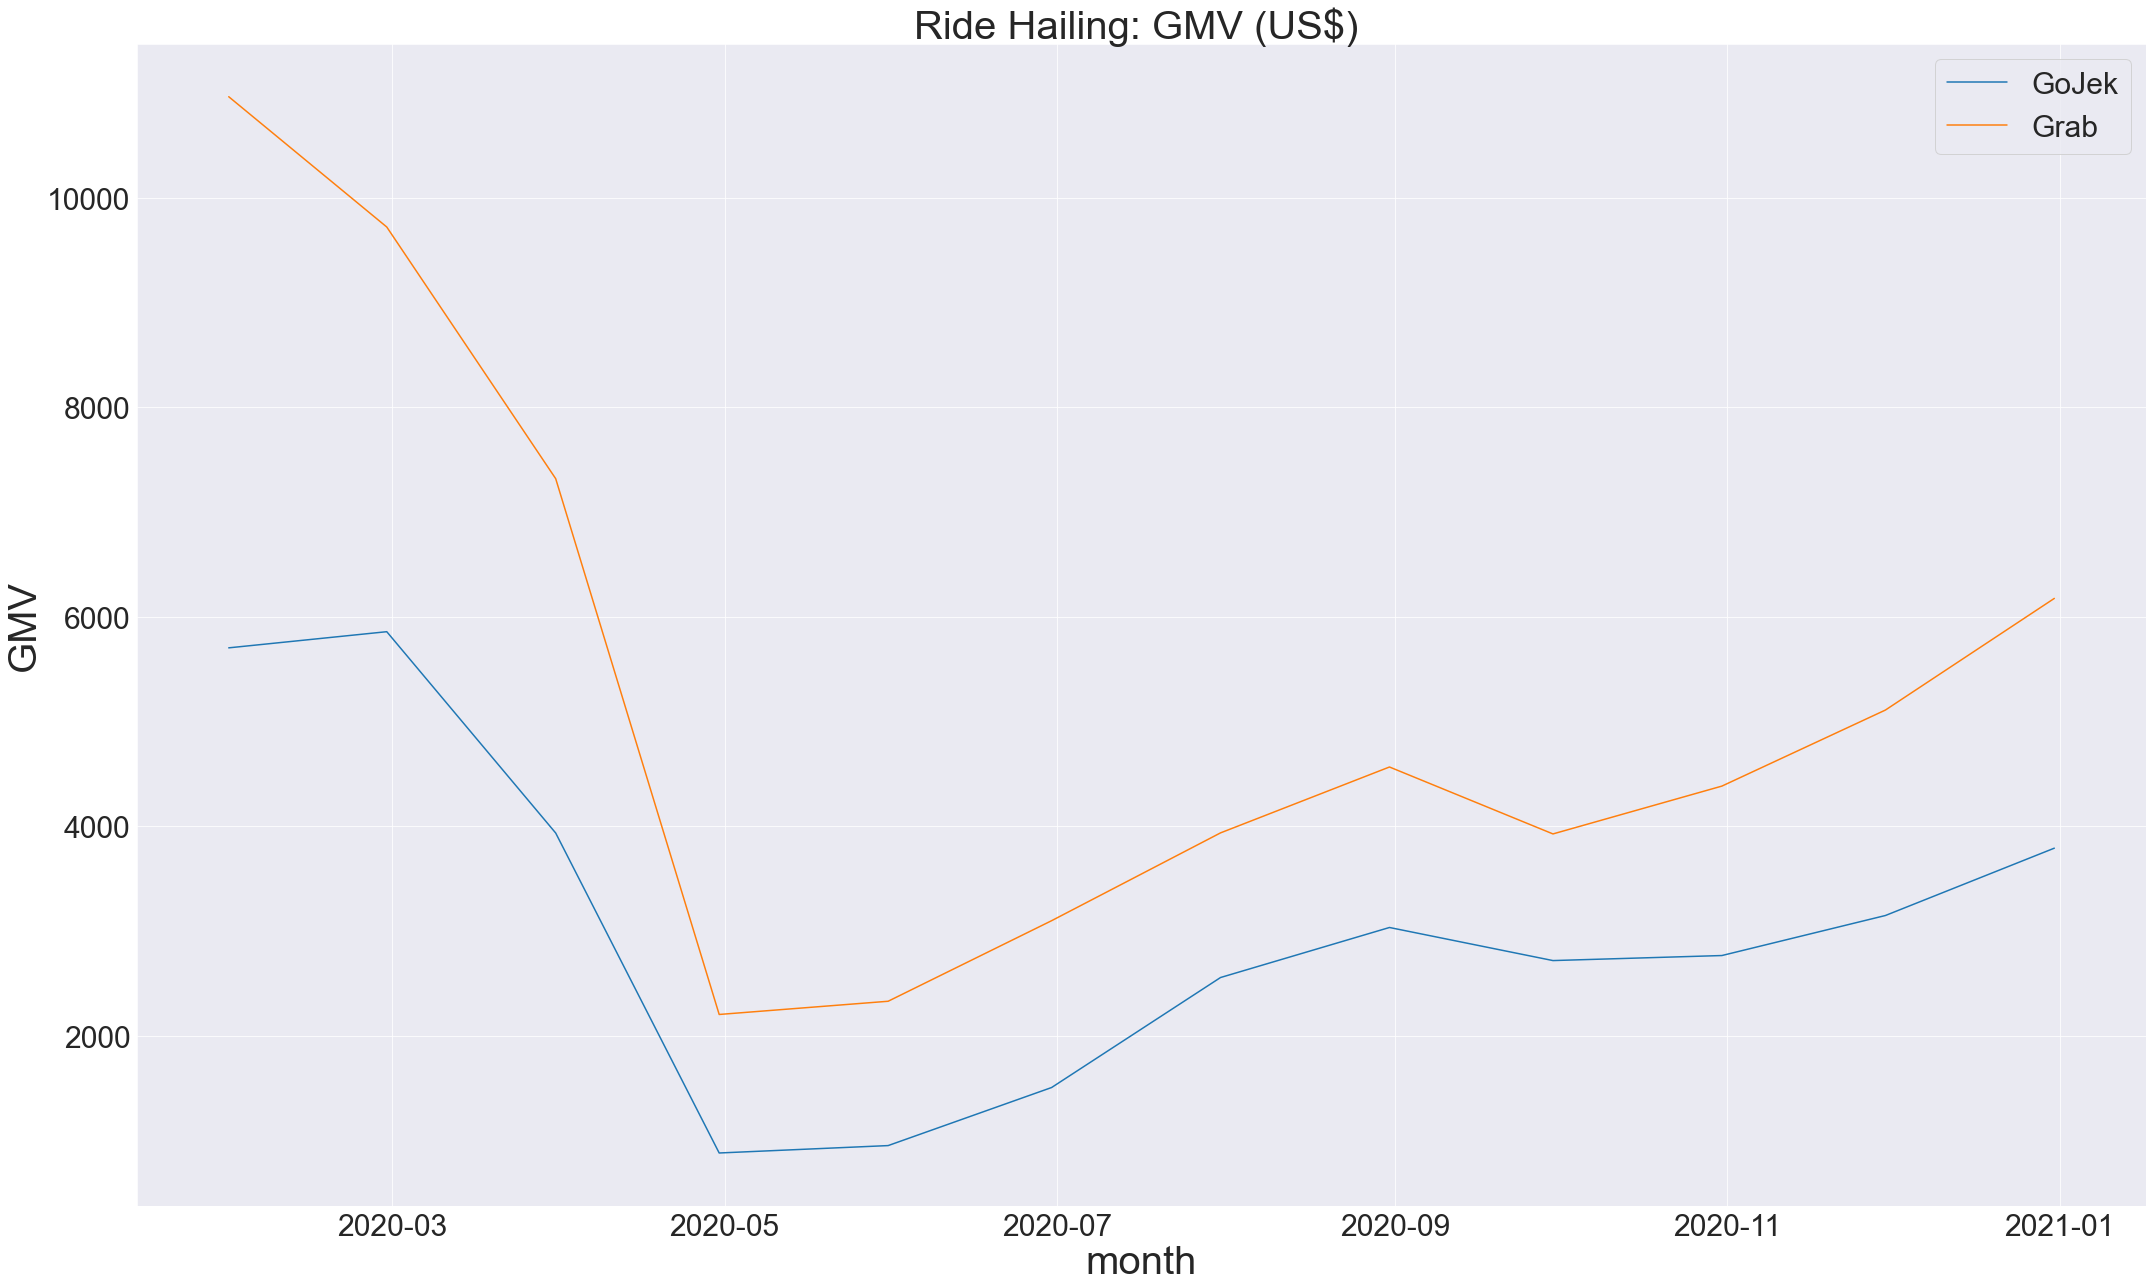

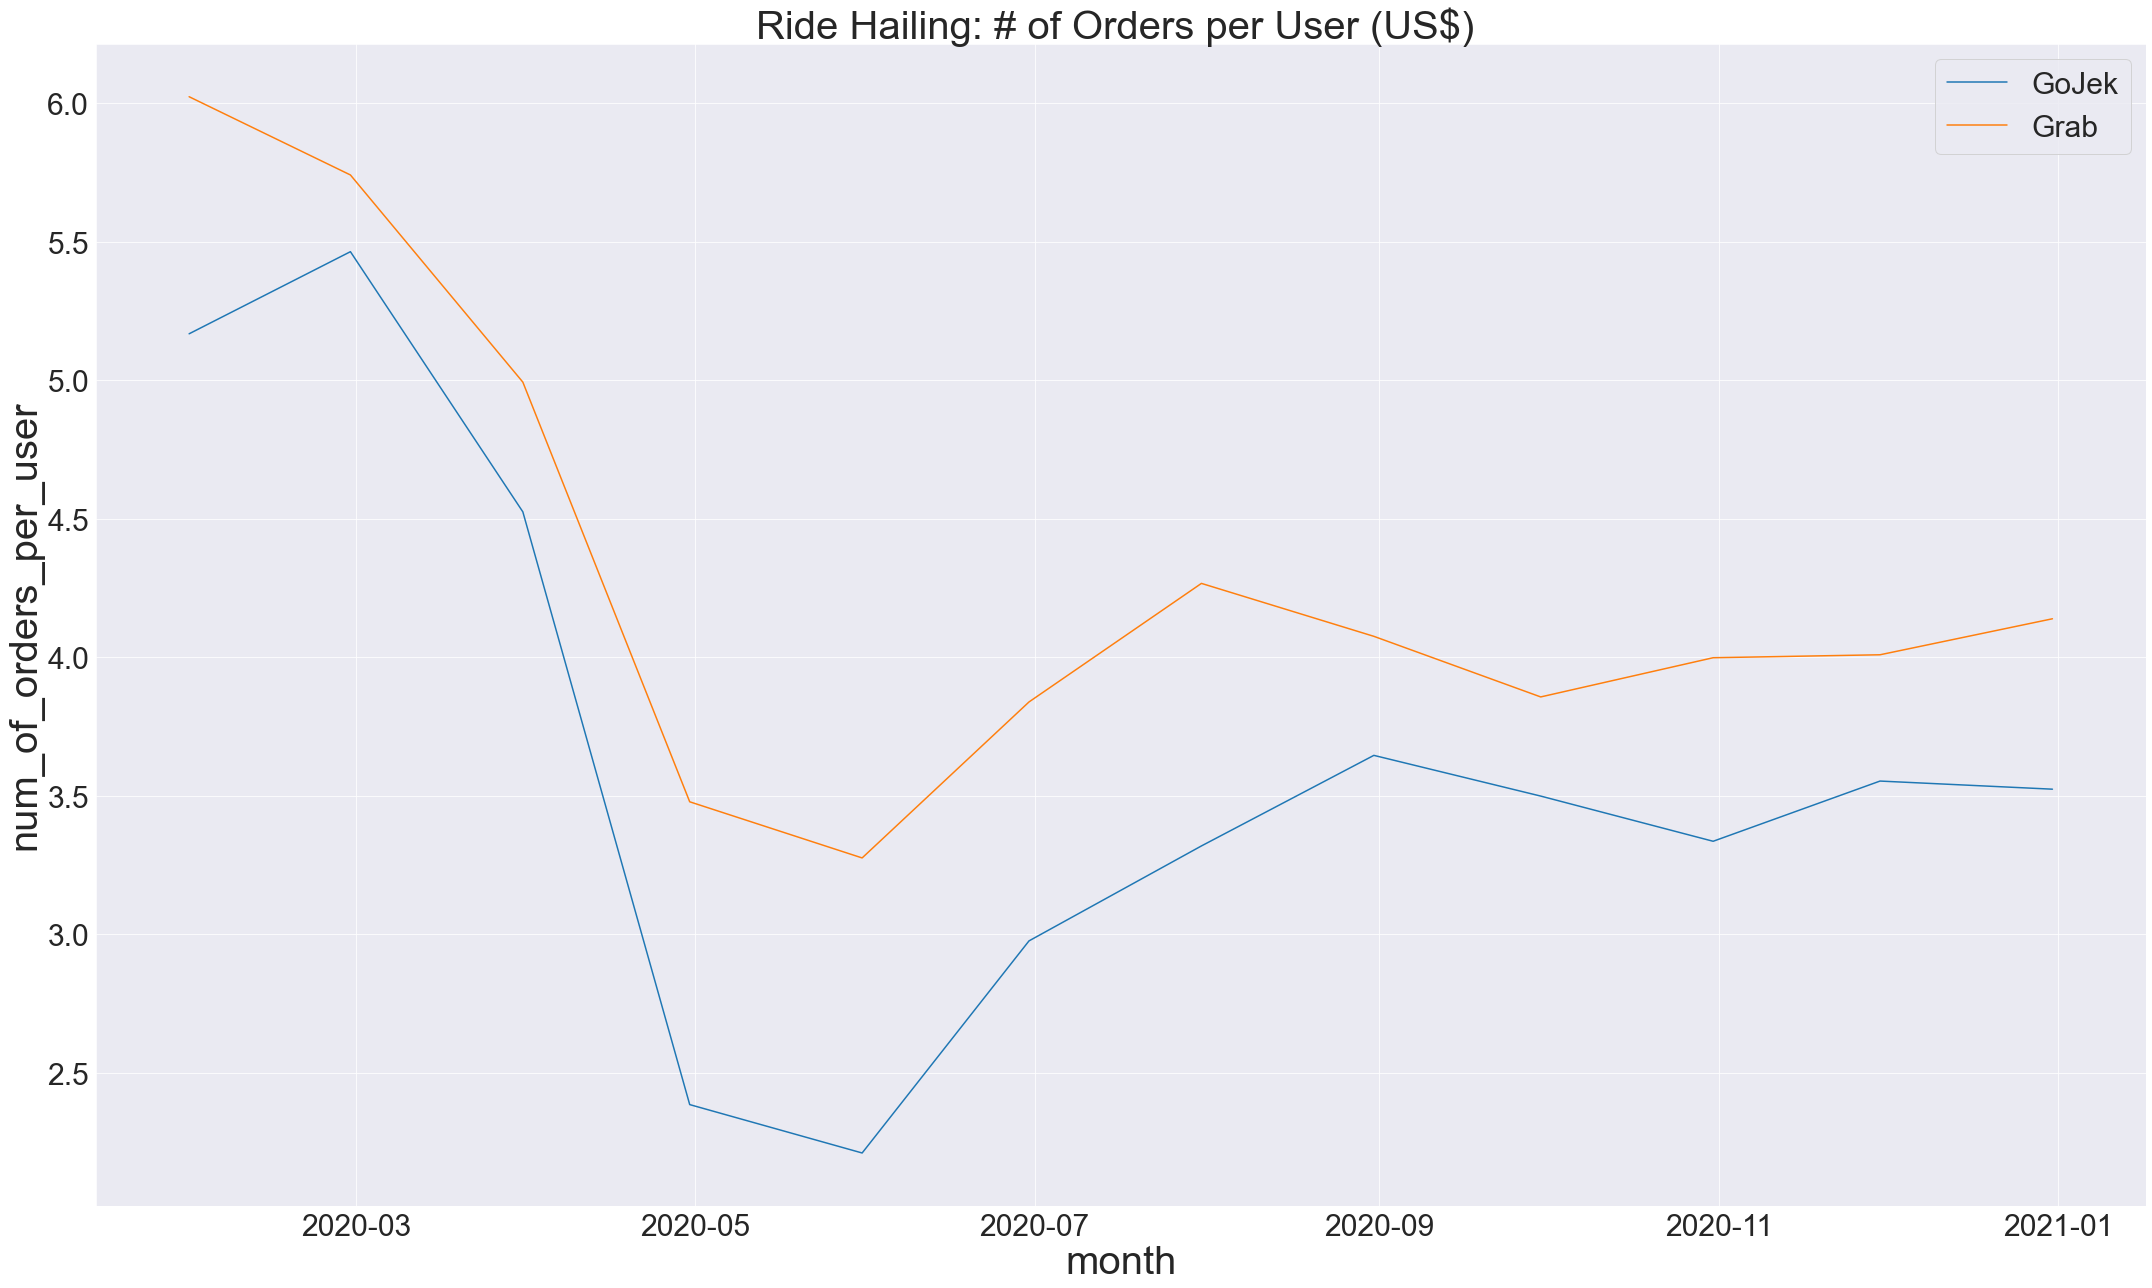

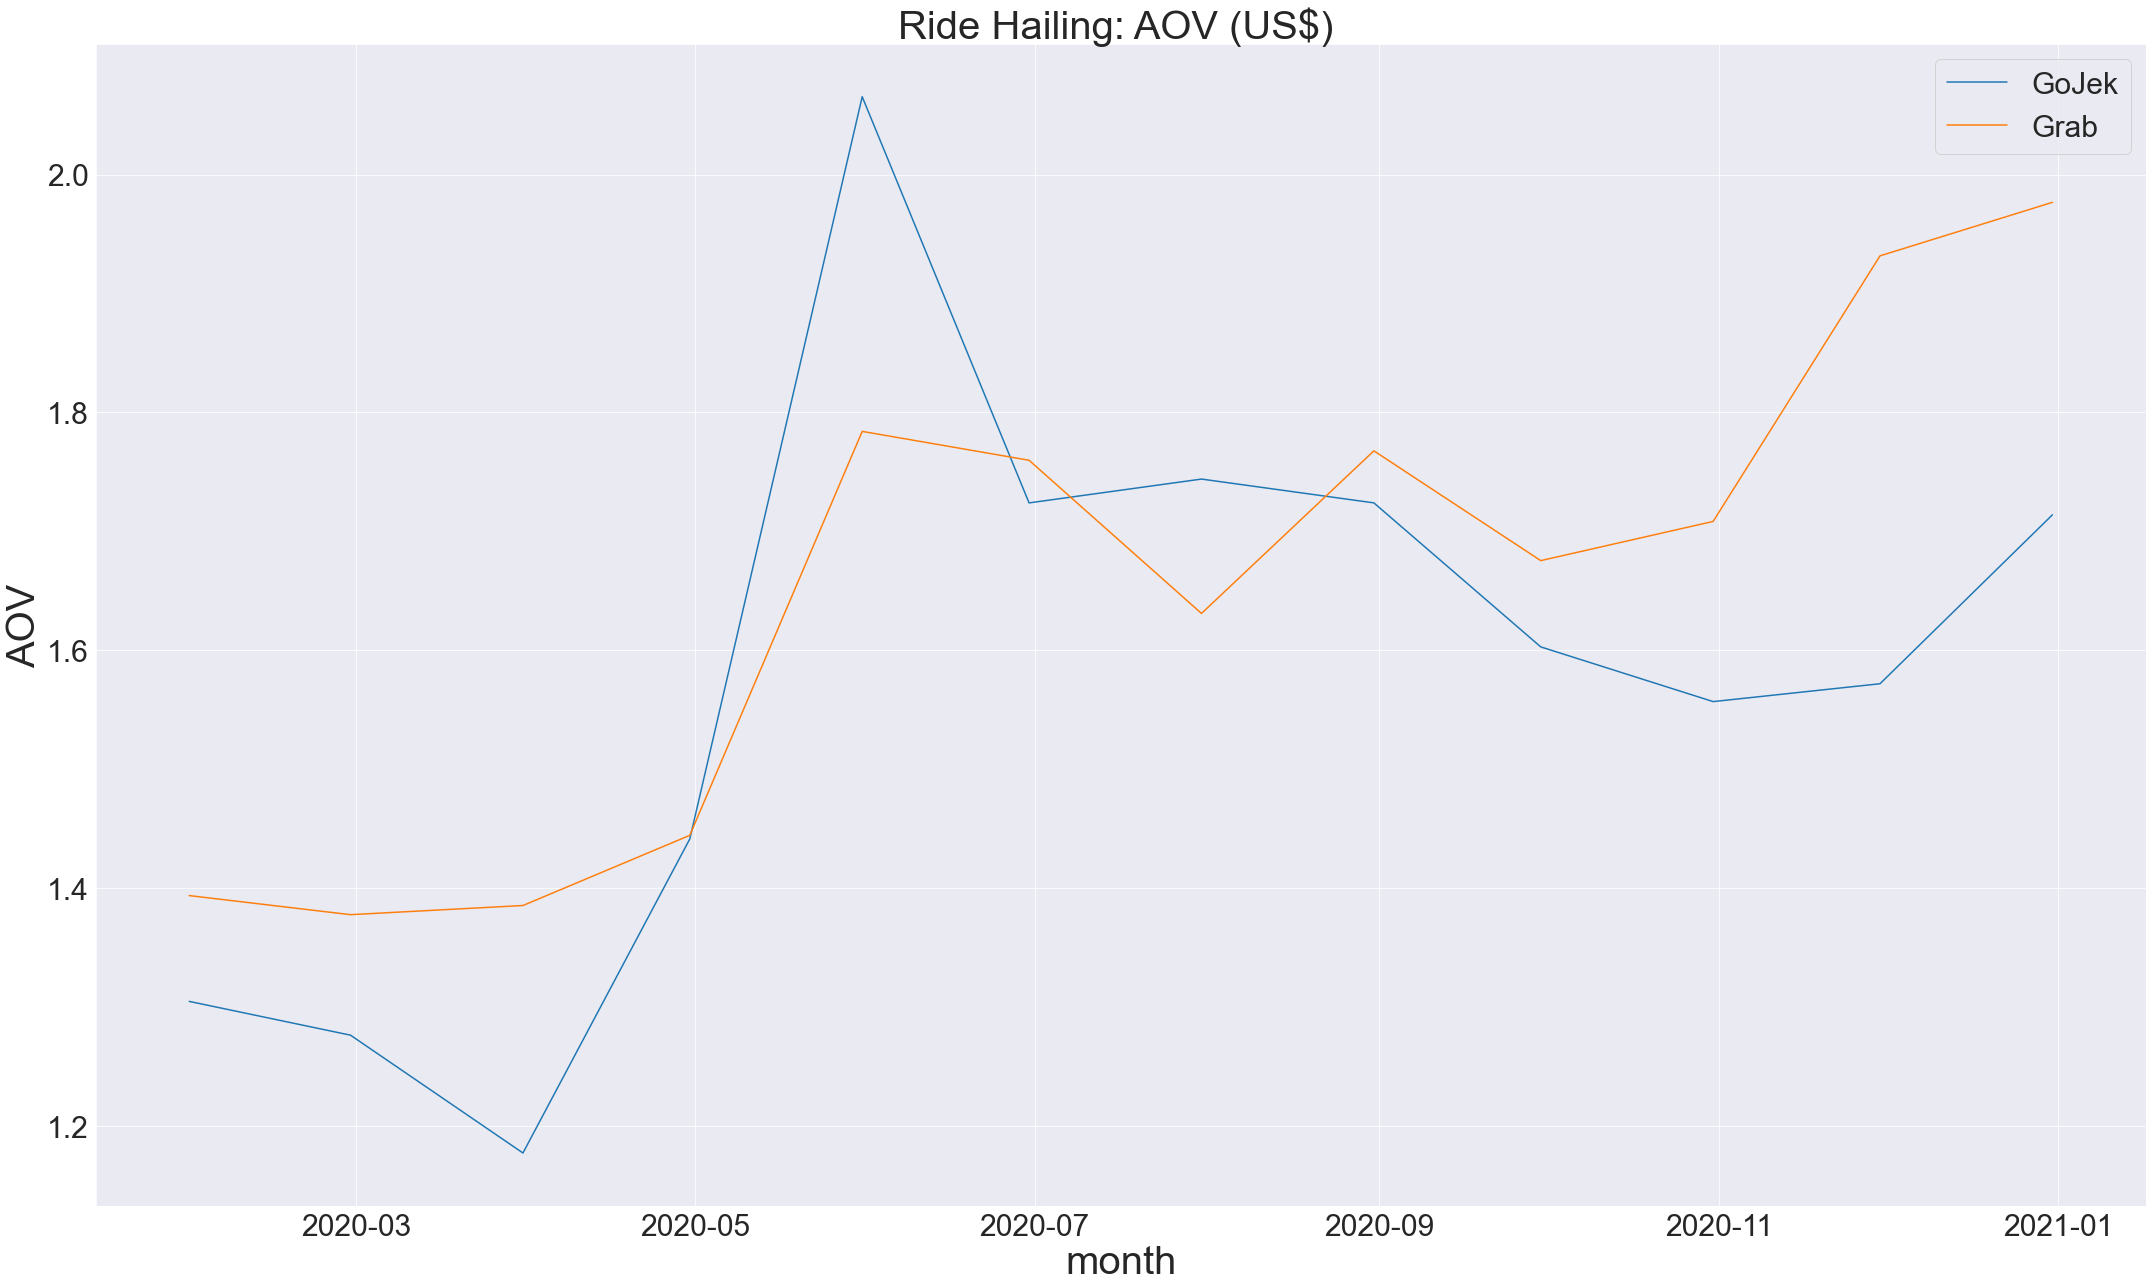

In [11]:
''' Time series of basic metrics '''

#chart group by country
sector = 'Ride Hailing'
platforms = None
country_list = ['Thailand', 'Malaysia']
group_by = PLATFORM_COL
chart_series_groupby = COUNTRY_COL
freq = 'Q'
df = get_time_series_of_user_basics(sector, country_list, group_by, chart_series_groupby, freq=freq)

#chart group by platform
sector = 'Ride Hailing'
platforms = ['Grab', 'GoJek']
country_list = ['Indonesia']
group_by = PLATFORM_COL
chart_series_groupby = PLATFORM_COL
freq = 'M'
grab_country = get_time_series_of_user_basics(sector, country_list, 'platform', 'platform', freq=freq)

In [14]:
def get_decomposition_by_cohorts(sector, country, platforms=None, freq='M'):
    '''
    sector: str
    country: str
    platforms: list default = None, include all available platforms under the sector
    freq: ['M','Q']


    Returns
    2 charts: time series of # of users & GMV
    by cohorts: churned, new, resurrected, retained
    2 dataframes of # of users & GMV  respectively
    -------

    '''

    def get_user_type(user_df, date_col, user_id, freq):
        '''
        params:
        user_df: df of user_id, date

        returns:
        assign a value for relevant user with one of the 4 types ['new', 'retained', 'resurrected', 'churned']
        '''
        first_period = f'first_{date_col}'
        new = user_df.groupby([user_id])[date_col].min().reset_index().rename(
            columns={date_col: first_period})
        user_df['val'] = 1
        user_df_pv = pd.pivot_table(user_df, index=[date_col], columns=[user_id], values='val')
        dates_t = pd.date_range(user_df_pv.index.min(), user_df_pv.index.max(), freq=freq)
        user_df_pv = user_df_pv.reindex(dates_t)

        user_df_pv = user_df_pv.fillna(0)

        user_df_pv_shift = user_df_pv.shift(1)
        user_df_pv_type = user_df_pv - user_df_pv_shift
        user_df_types = user_df_pv_type.unstack().reset_index().rename(columns={'level_1': date_col,
                                                                                0: 'type'})
        user_types = user_df_types.merge(new, on=[user_id], how='left')
        user_types = user_types[
            user_types[date_col] >= user_types[first_period]]
        user_types_current = user_df_pv.unstack().reset_index().rename(columns={'level_1': date_col,
                                                                                0: 'current_type'})
        user_types_current = user_types.merge(user_types_current, on=[user_id, date_col],
                                              how='left')
        user_types_current['type_name'] = np.where(
            user_types_current[date_col] == user_types_current[first_period],
            'new',
            np.where((user_types_current.type == 0) & (user_types_current.current_type == 1),
                     'retained',
                     np.where((user_types_current.type == 1) & (user_types_current.current_type == 1),
                              'resurrected',
                              np.where((user_types_current.type == -1) & (user_types_current.current_type == 0),
                                       'churned', None))))
        type_df = user_types_current.groupby([date_col, 'type_name'])[user_id].nunique() \
            .reset_index().rename(columns={user_id: 'user_count'})
        type_df['user_count'] = np.where(type_df.type_name == 'churned', -type_df.user_count, type_df.user_count)
        type_df_pv = pd.pivot(type_df, index=date_col, columns='type_name', values='user_count')
        type_df_pv.reset_index(inplace=True)
        user_types_current = user_types_current[[USER_ID, date_col, 'type_name']].dropna(subset=['type_name'])
        # type_df_pv[date_col] = type_df_pv[date_col].map(lambda i: i.strftime('%Y/%m'))
        return user_types_current, type_df_pv

    df = get_raw_data(sector, platforms, [country])
    output_date_col = DATE_COL_DICT[freq]

    df[output_date_col] = get_resampled_date(freq, df[DATE_COL].tolist())
    type = df[[USER_ID, output_date_col]].drop_duplicates()
    type_df, user_type_cnt = get_user_type(type, output_date_col, USER_ID, freq=freq)
    df[output_date_col] = pd.to_datetime(df[output_date_col])
    gmv_user_type = df.groupby([USER_ID, output_date_col])[GMV_COL].sum().reset_index()
    gmv_user_type_df = gmv_user_type.merge(type_df.set_index([USER_ID, output_date_col]), on=[USER_ID, output_date_col],
                                           how='left')
    gmv_user_type_df = gmv_user_type_df.groupby([output_date_col, 'type_name'])[GMV_COL].sum().reset_index()
    gmv_user_type_df = pd.pivot(gmv_user_type_df,
                                values=GMV_COL,
                                index=output_date_col,
                                columns='type_name').reset_index()
    # num of users by cohorts
    if platforms is None:
        platforms = []
    elif set(platforms) == set(SECTOR_COMPANY.get(sector)):
        platforms = []
    else:
        platforms = [', '.join(platforms)]

    country_sector_platform = ' - '.join(['%s | %s' % (country, sector)] + platforms)
    title = ' %s : # of Users by cohorts' % country_sector_platform
    plot_user_corhort_chart(user_type_cnt, output_date_col, title, x_col=output_date_col)

    # GMV by cohorts
    title = '%s GMV (US$) by cohorts' % country_sector_platform
    plot_user_corhort_chart(gmv_user_type_df, output_date_col, title, x_col=output_date_col)
    user_type_cnt['country'] = country
    gmv_user_type_df['country'] = country
    return user_type_cnt, gmv_user_type_df


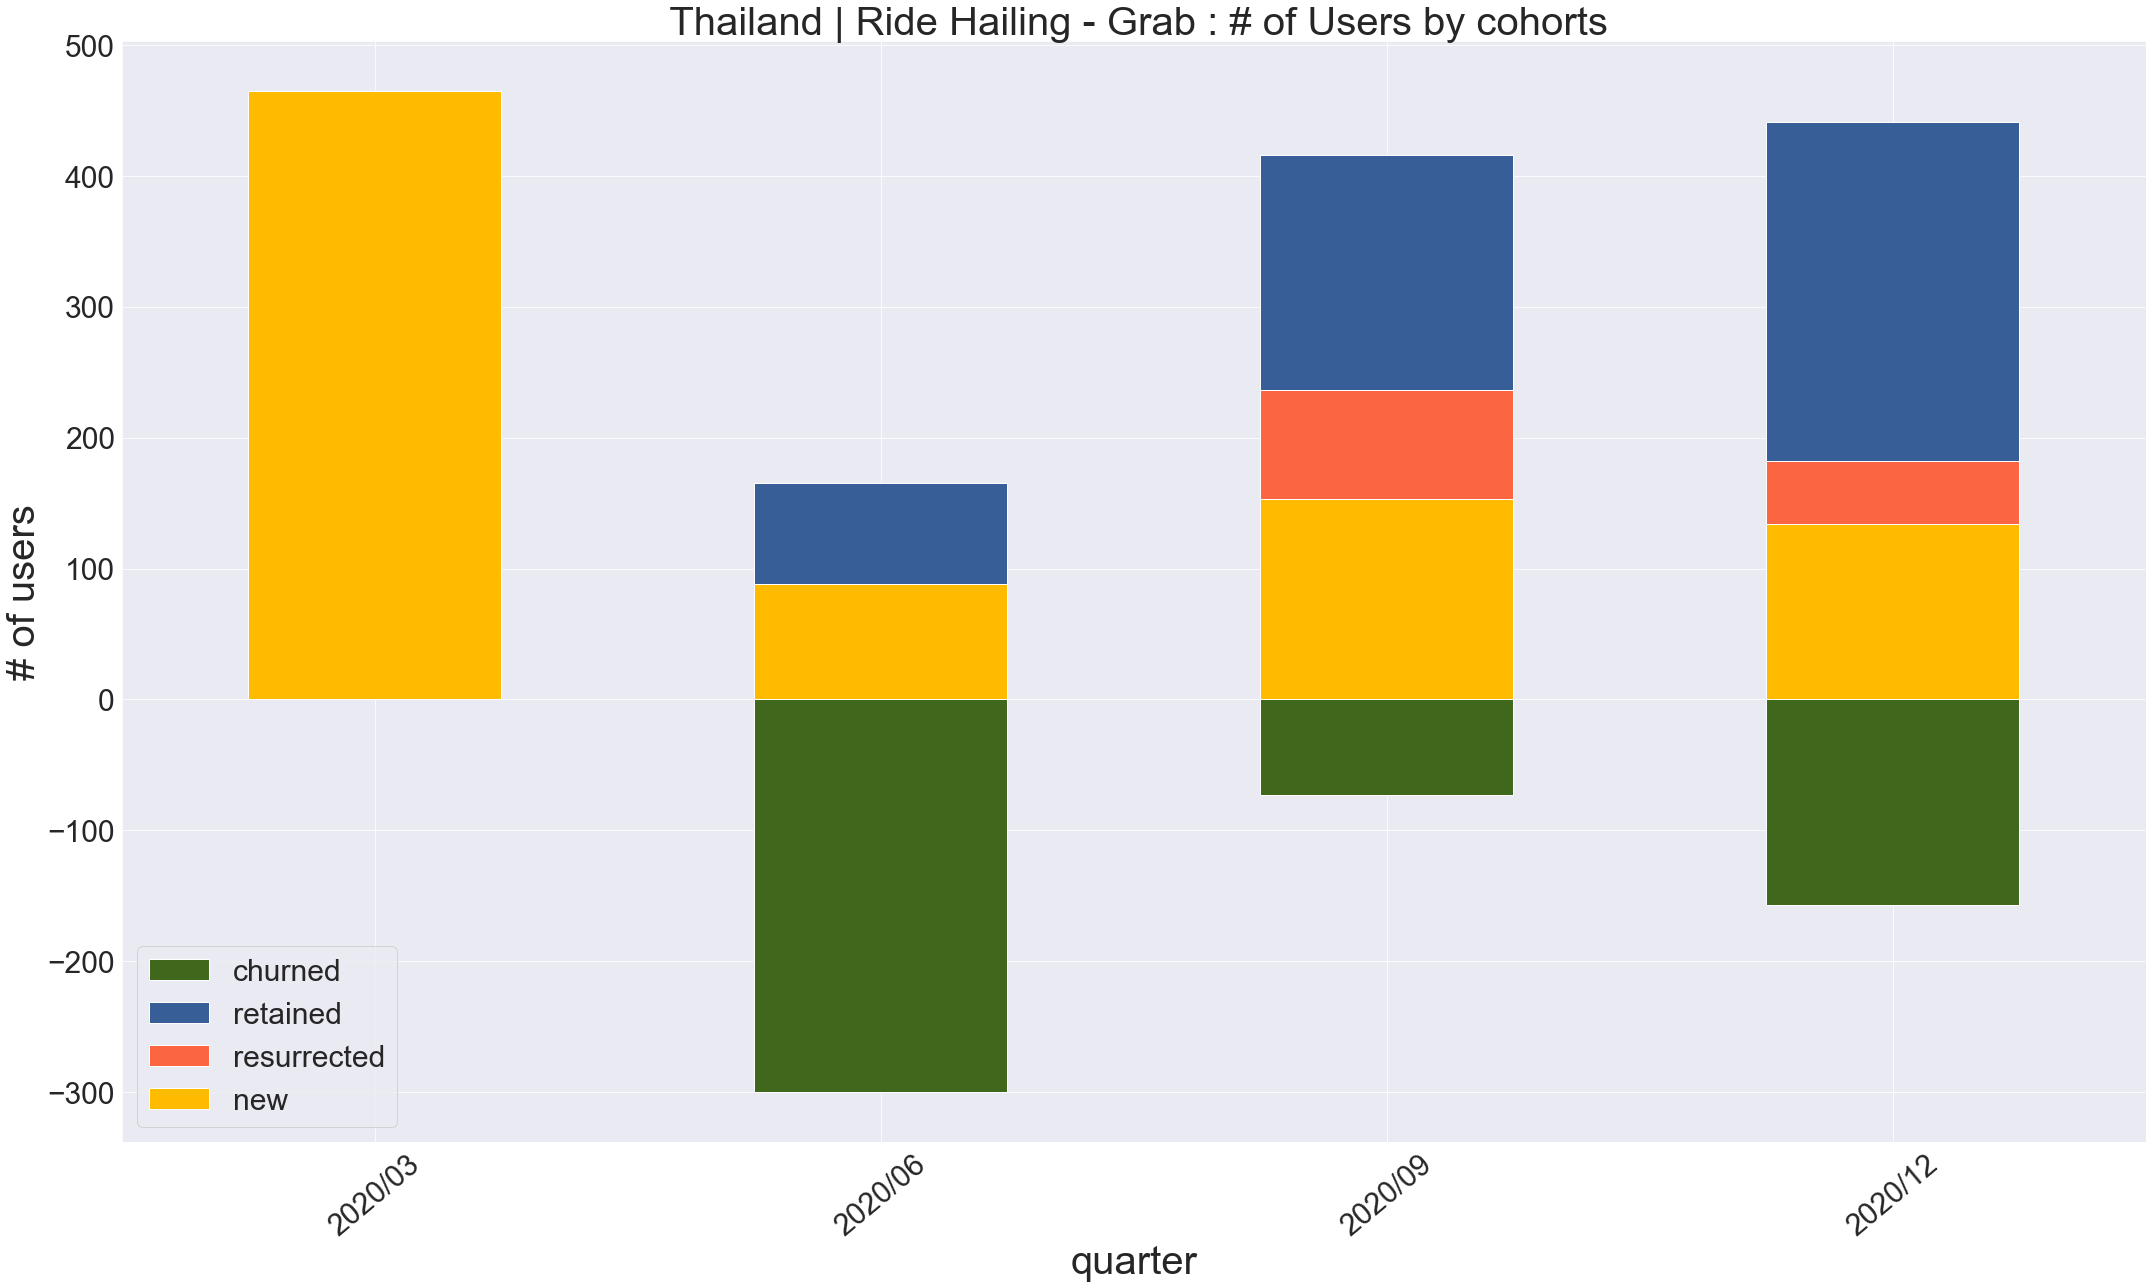

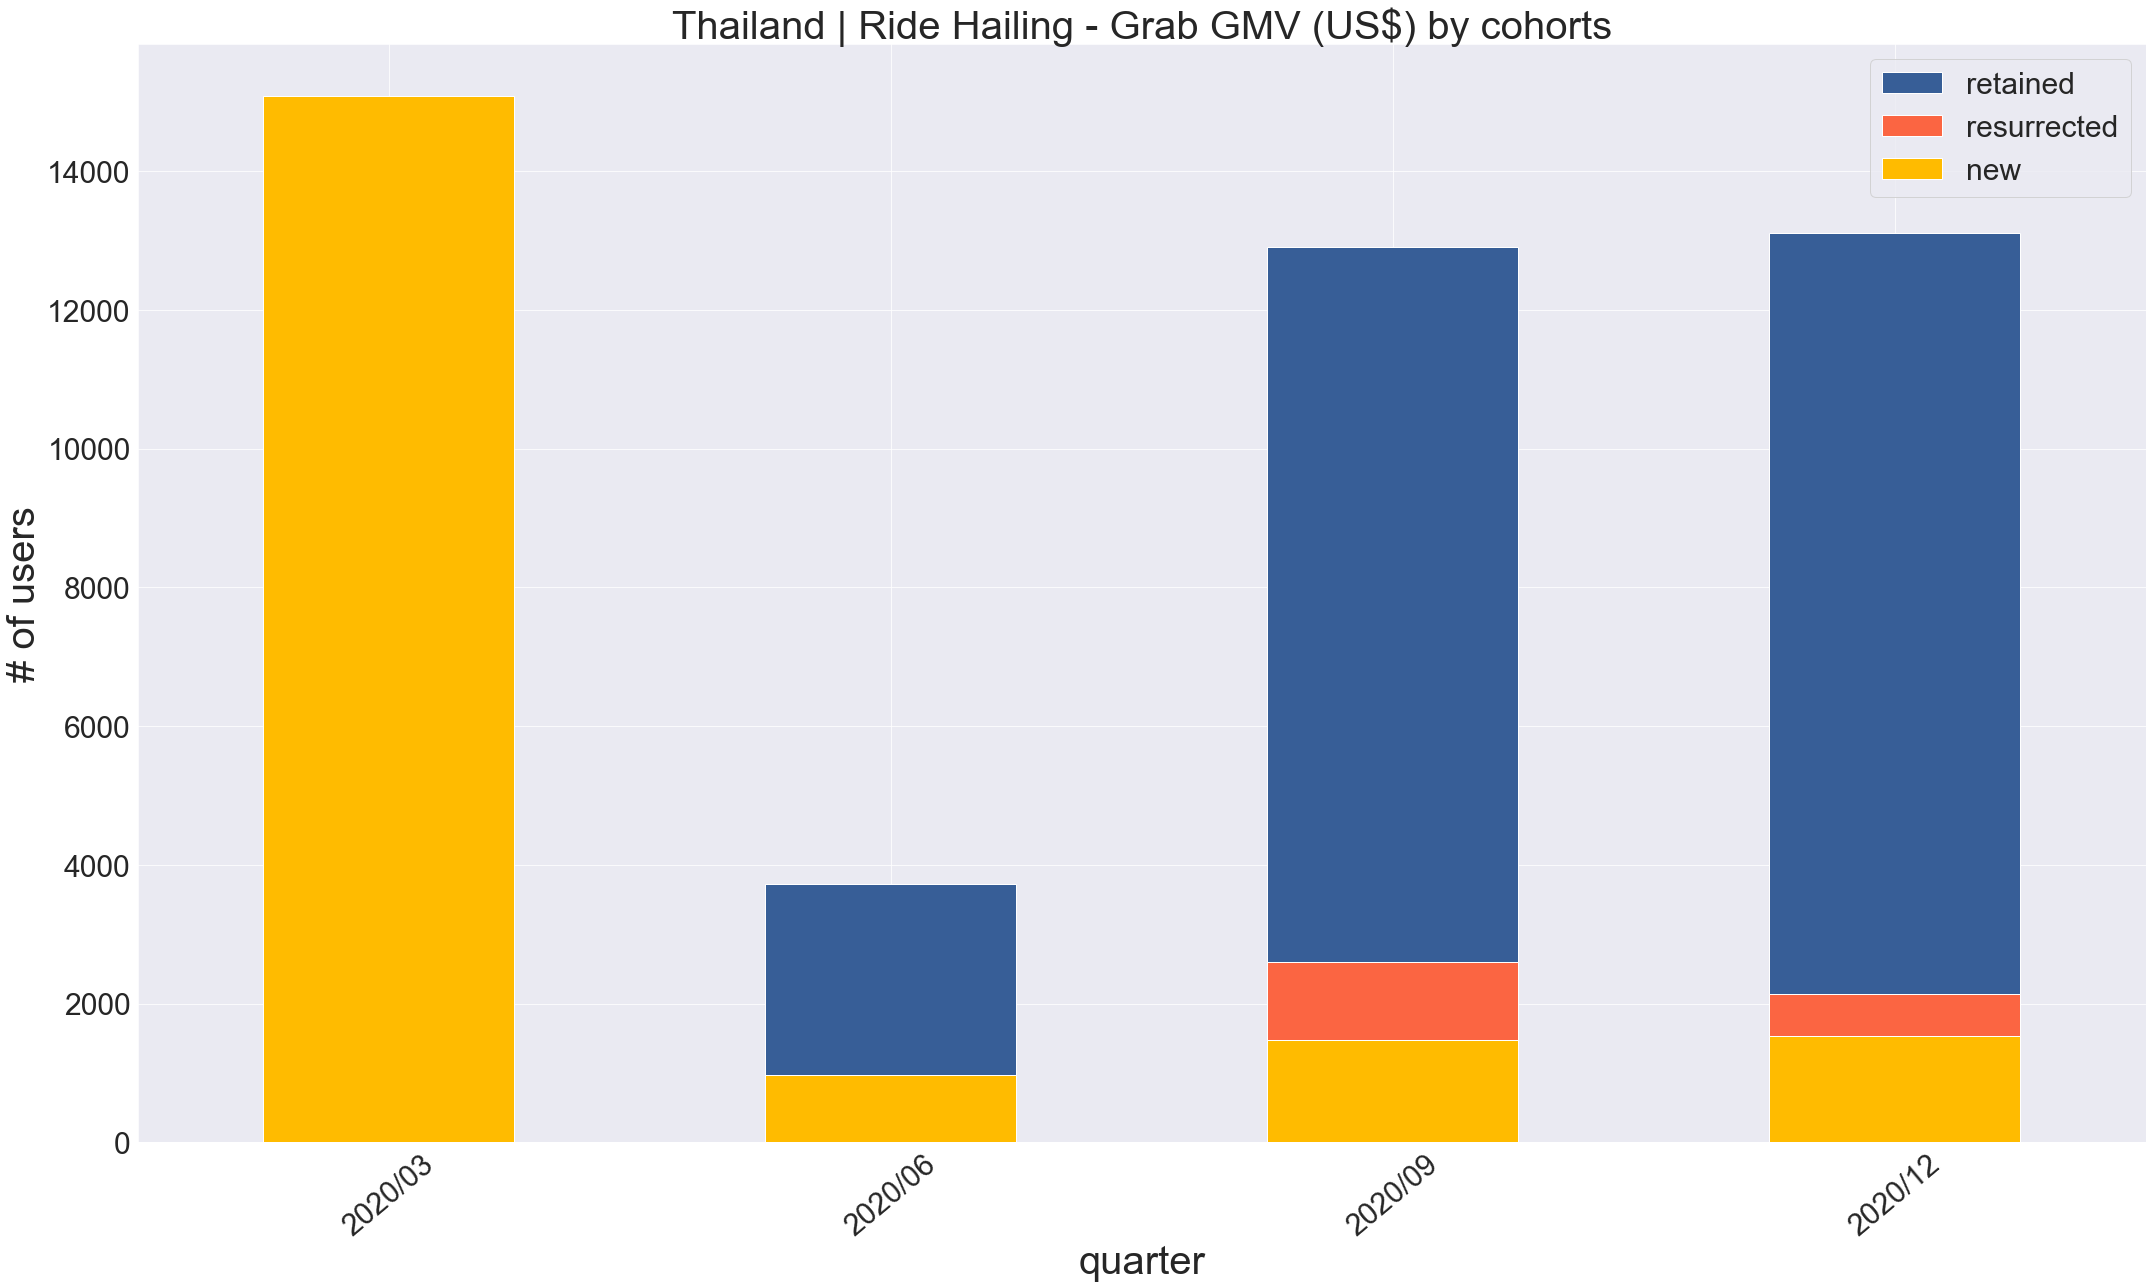

In [15]:
sector, country, platforms = 'Ride Hailing', 'Thailand', ['Grab']
freq = 'Q'
user_type_cnt, gmv_user_type_df = get_decomposition_by_cohorts(sector, country, platforms, freq=freq)

In [18]:
def using_platforms_time_series(country, sector, platforms=None, freq='M'):
    '''

    Parameters
    ----------
    country: str name of country
    sector: str
    platforms: list default = None, include all available platforms in selected country
    freq: ['M','Q']

    Returns

    df of user count by # of platform
    -------

    '''

    df = get_raw_data(sector, platforms, [country])
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    output_date_col = DATE_COL_DICT[freq]
    df[output_date_col] = get_resampled_date(freq, df[DATE_COL].tolist())

    # df.set_index(DATE_COL, inplace=True)
    user_platform_cnt = df.groupby([USER_ID, output_date_col])['platform'].nunique().reset_index().rename(
        columns={'platform': 'platform_cnt'}).query('platform_cnt>0')
    multiple_platform_user_cnt = user_platform_cnt.groupby([output_date_col, 'platform_cnt'])[
        USER_ID].nunique().reset_index() \
        .rename(columns={USER_ID: 'user_count'})
    multiple_platform_user_cnt = pd.pivot(multiple_platform_user_cnt,
                                          index=[output_date_col], columns='platform_cnt', values='user_count')
    multiple_platform_user_cnt.index = [i for i in multiple_platform_user_cnt.index]

    country_sector_platform = '%s | %s' % (country, sector)
    title = ' %s : # of Users by # of Platforms Used' % country_sector_platform
    y_label = '# of Users'
    plot_stacked_chart_with_crosstabed_df(multiple_platform_user_cnt, title, y_label, x_label=output_date_col,
                                          lengend_loc='best')
    return multiple_platform_user_cnt


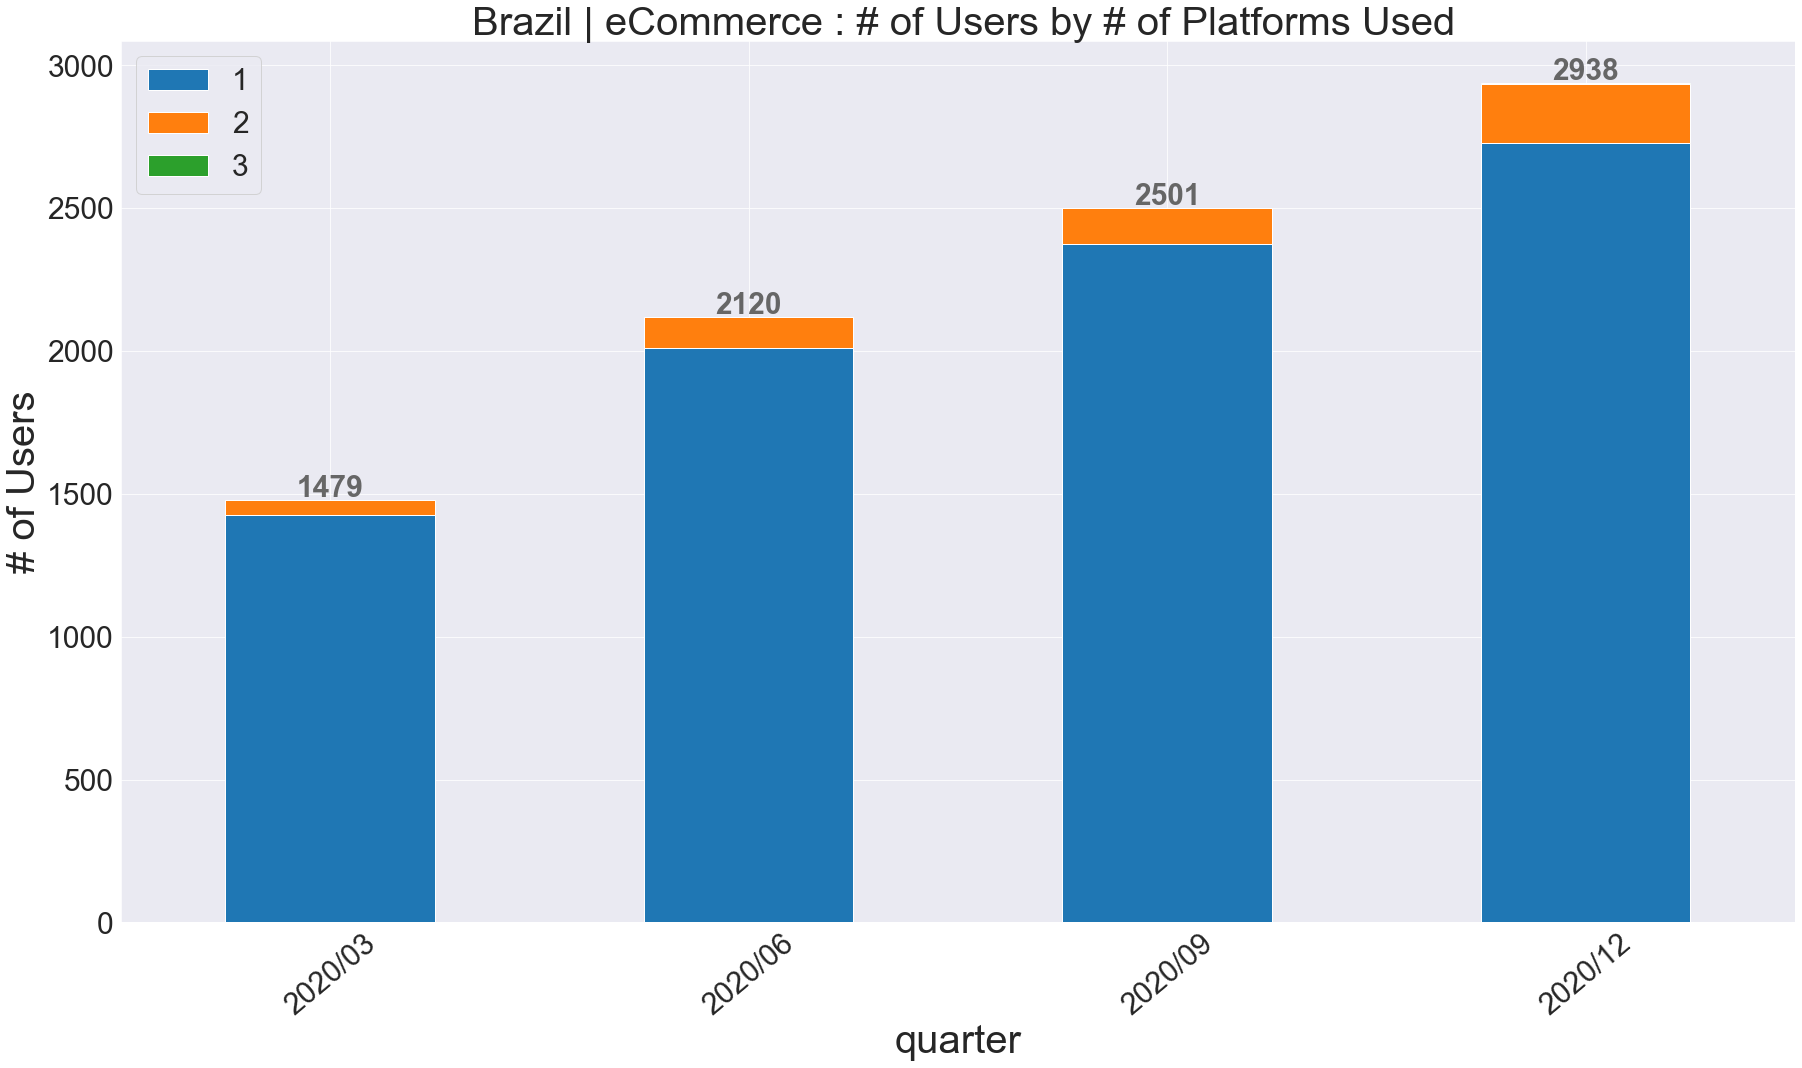

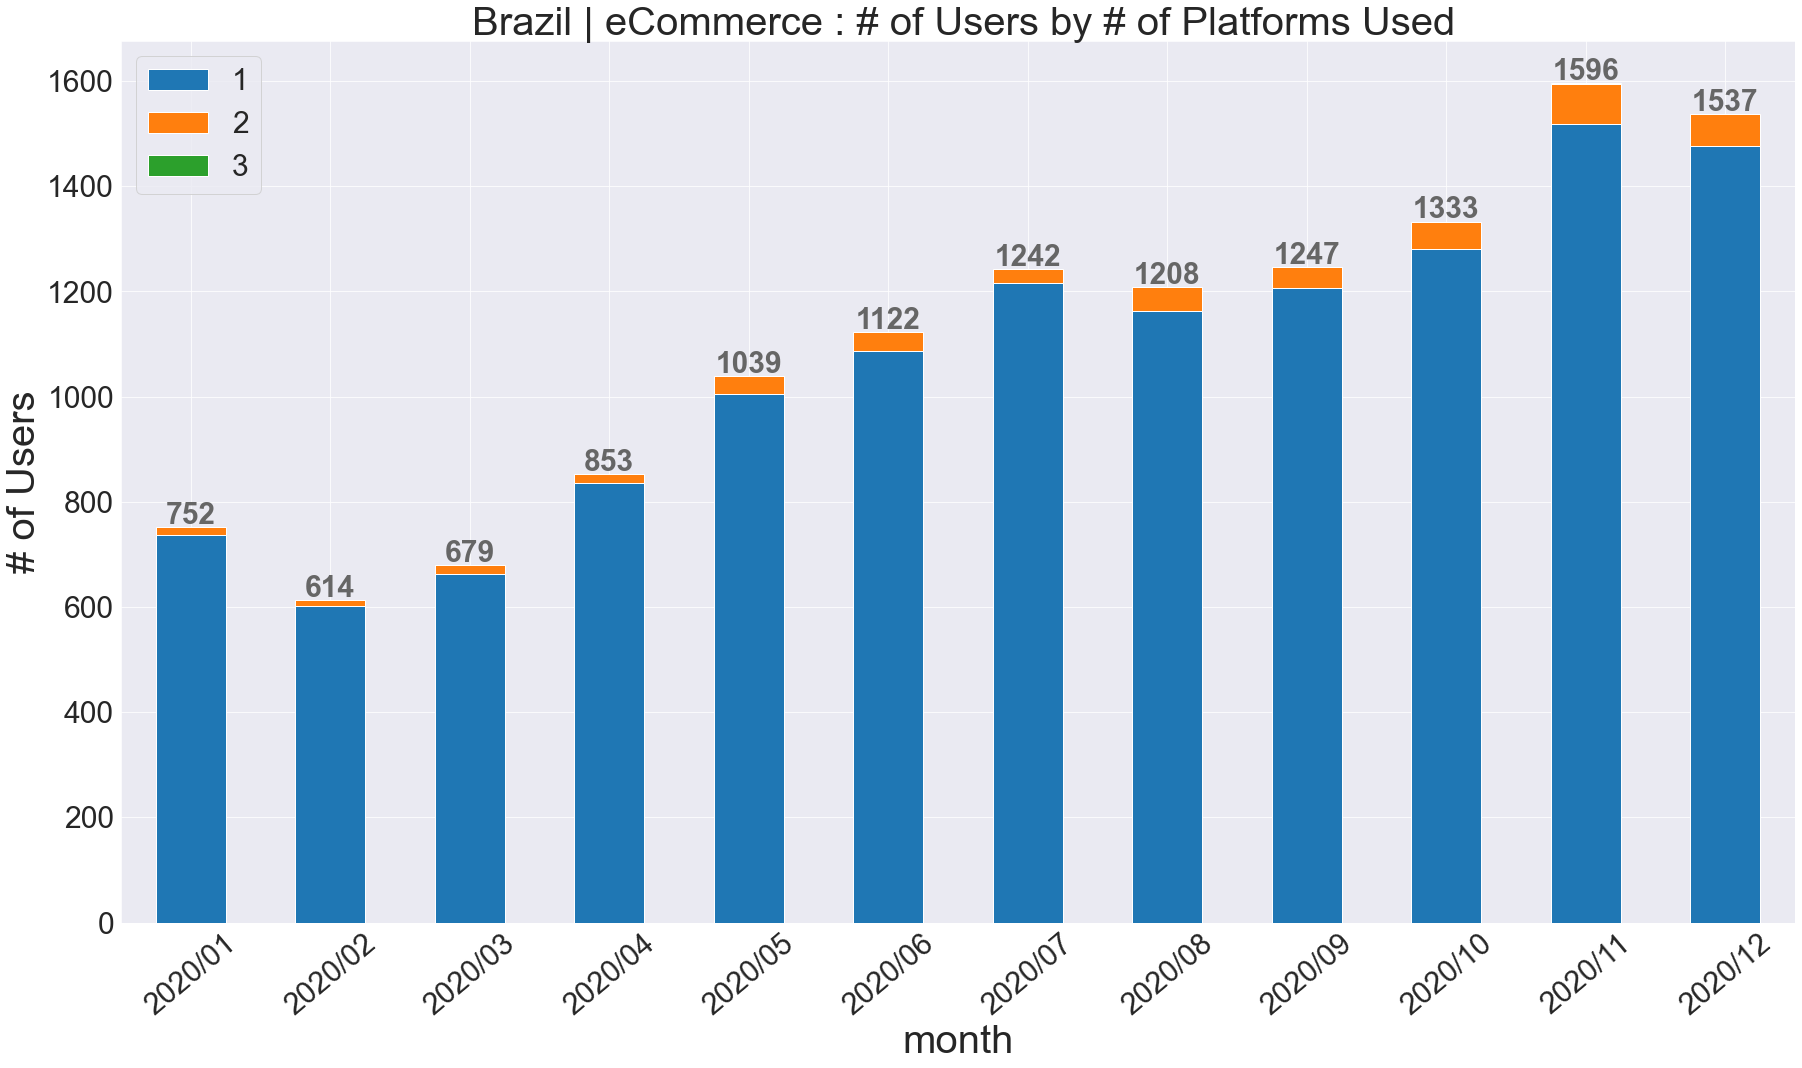

In [20]:
sector = 'eCommerce'
platforms = None
country = 'Brazil'
freq = 'Q'
multiple_platofrm_users = using_platforms_time_series(country, sector, platforms=None, freq=freq)


freq = 'M'
multiple_platofrm_users = using_platforms_time_series(country, sector, platforms=None, freq=freq)

In [23]:
def overlapping_platforms_given_platform(country, given_platform, sector, freq='M'):
    '''

    Parameters
    ----------
    country
    given_platform
    sector
    freq ['M', 'Q']

    Returns
    grouped bar chart time series
    df for overlapping pct
    -------

    '''
    platforms = None
    df = get_raw_data(sector, platforms, [country])
    given_df = df[df[PLATFORM_COL] == given_platform]
    if len(given_df) == 0:
        raise ValueError('can not find relevant platform %s in country %s' % (given_platform, country))
    output_date_col = DATE_COL_DICT[freq]
    df[output_date_col] = get_resampled_date(freq, df[DATE_COL].tolist())

    df = df[[USER_ID, output_date_col, PLATFORM_COL]].drop_duplicates(subset=[USER_ID, output_date_col, PLATFORM_COL])
    df['val'] = 1
    df_ = pd.pivot_table(df, index=[USER_ID, output_date_col], columns=PLATFORM_COL, values='val',
                         fill_value=0).reset_index()
    df_ = df_[df_[given_platform] == 1].drop(columns=[USER_ID])
    out = df_.groupby(output_date_col).mean().reset_index().drop(columns=[given_platform])
    out = out.melt(id_vars=[output_date_col], var_name="platform",
                   value_name="overlapping_pct")
    out['overlapping_pct'] = (out['overlapping_pct'] * 100).map(lambda i: np.round(i, 1))
    country_sector_platform = '%s | %s' % (country, sector)
    y_col = 'overlapping_pct'
    hue_col = 'platform'
    x_label = output_date_col

    title = '{}: {} Users Also Use (%)'.format(country_sector_platform, given_platform)
    y_label = '% of overlapping users'
    multiple_bar_with_labels(out, output_date_col, y_col, hue_col, x_label, y_label, title, lengend_loc='best',
                             y_lim=[0, 100])
    return out


def overlapping_platforms_given_platform_any_sectors(country, given_platform, sectors, freq='M'):
    '''
    Parameters
    ----------
    country
    given_platform
    sectors list of sector
        if None, scan all available sectors
    freq = ['M', 'Q']

    Returns
    grouped bar chart time series
    df for overlapping pct
    -------

    '''

    df, _ = get_any_sector_raw_df(given_platform, country, sectors, platforms=None)
    given_df = df[df[PLATFORM_COL] == given_platform]
    if len(given_df) == 0:
        raise ValueError('can not find relevant platform %s in country %s' % (given_platform, country))
    output_date_col = DATE_COL_DICT[freq]
    df[output_date_col] = get_resampled_date(freq, df[DATE_COL].tolist())

    df = df[[USER_ID, output_date_col, PLATFORM_COL]].drop_duplicates(subset=[USER_ID, output_date_col, PLATFORM_COL])
    df['val'] = 1
    df_ = pd.pivot_table(df, index=[USER_ID, output_date_col], columns=PLATFORM_COL, values='val',
                         fill_value=0).reset_index()
    df_ = df_[df_[given_platform] == 1].drop(columns=[USER_ID])
    out = df_.groupby(output_date_col).mean().reset_index().drop(columns=[given_platform])
    out = out.melt(id_vars=[output_date_col], var_name="platform",
                   value_name="overlapping_pct")
    out['overlapping_pct'] = (out['overlapping_pct'] * 100).map(lambda i: np.round(i, 1))
    country_sector_platform = '%s | %s' % (country, ', '.join(sectors))
    y_col = 'overlapping_pct'
    hue_col = 'platform'
    x_label = output_date_col

    title = '{}: {} Users Also Use (%)'.format(country_sector_platform, given_platform)
    y_label = '% of overlapping users'
    multiple_bar_with_labels(out, output_date_col, y_col, hue_col, x_label, y_label, title, lengend_loc='best',
                             y_lim=[0, 100])
    return out



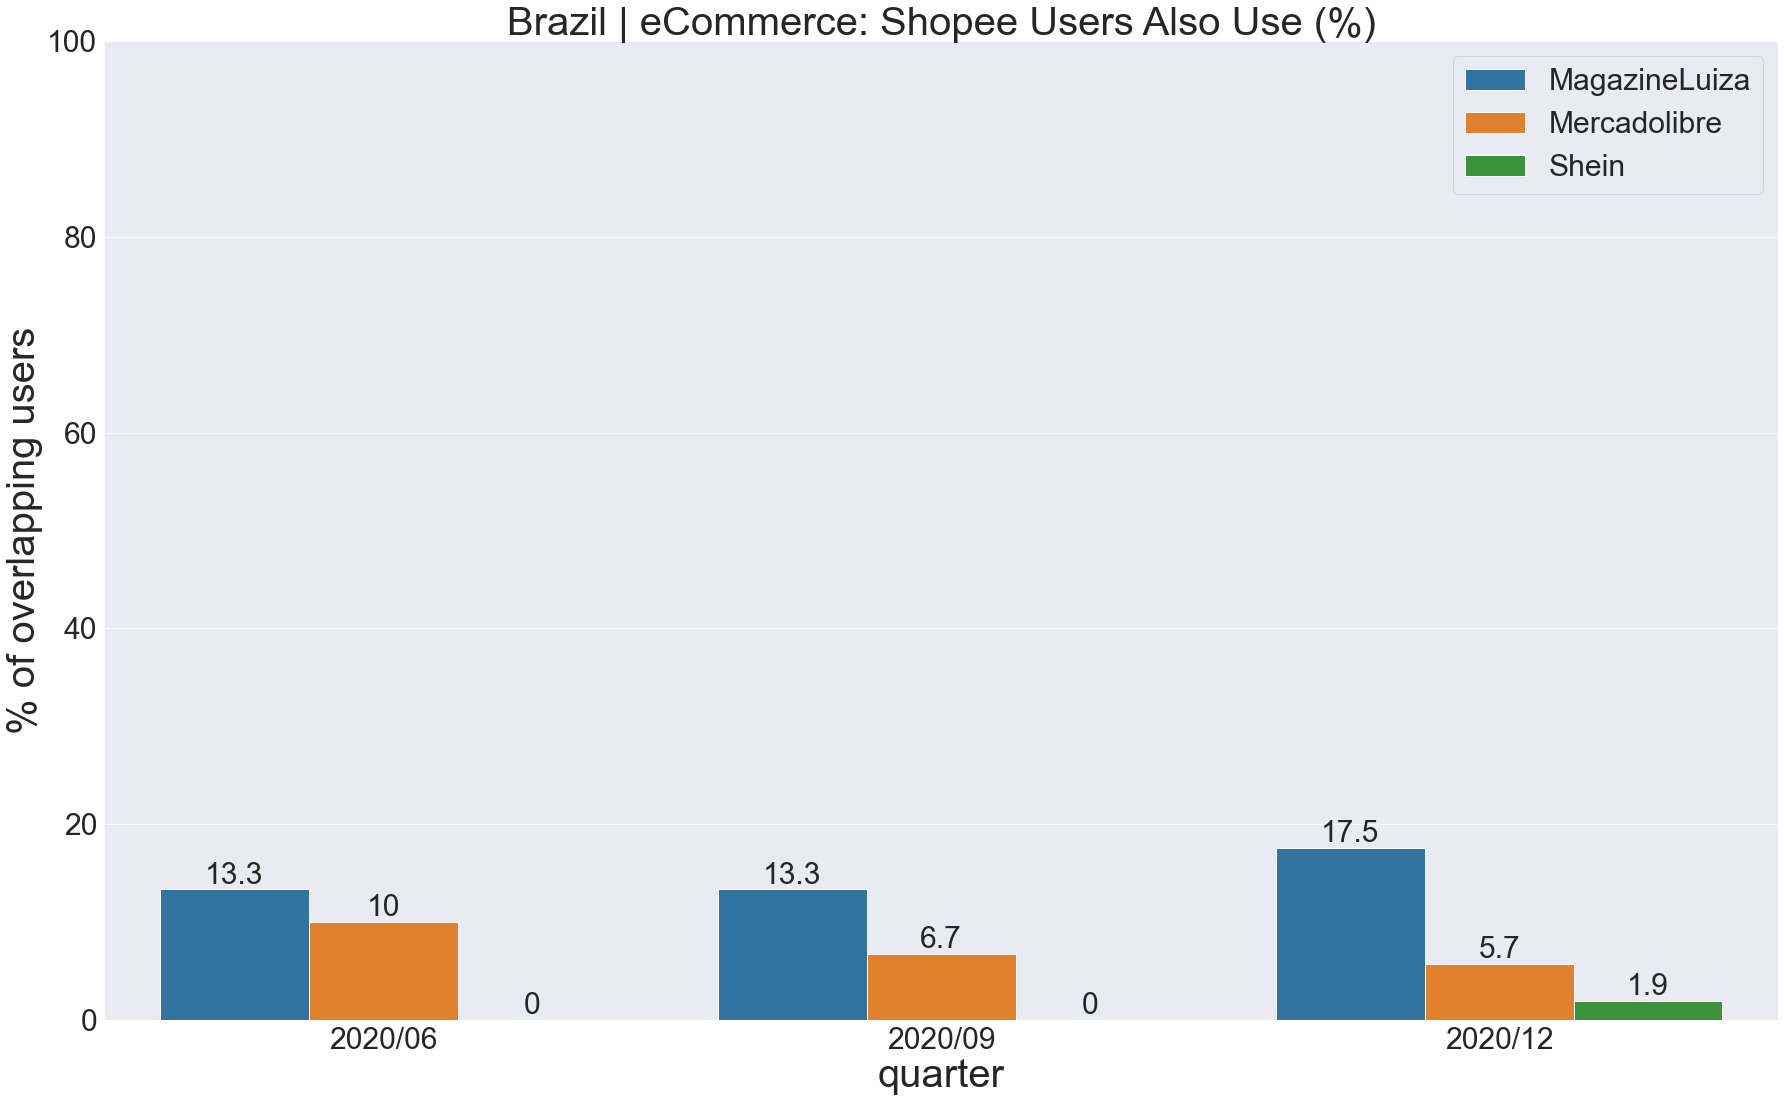

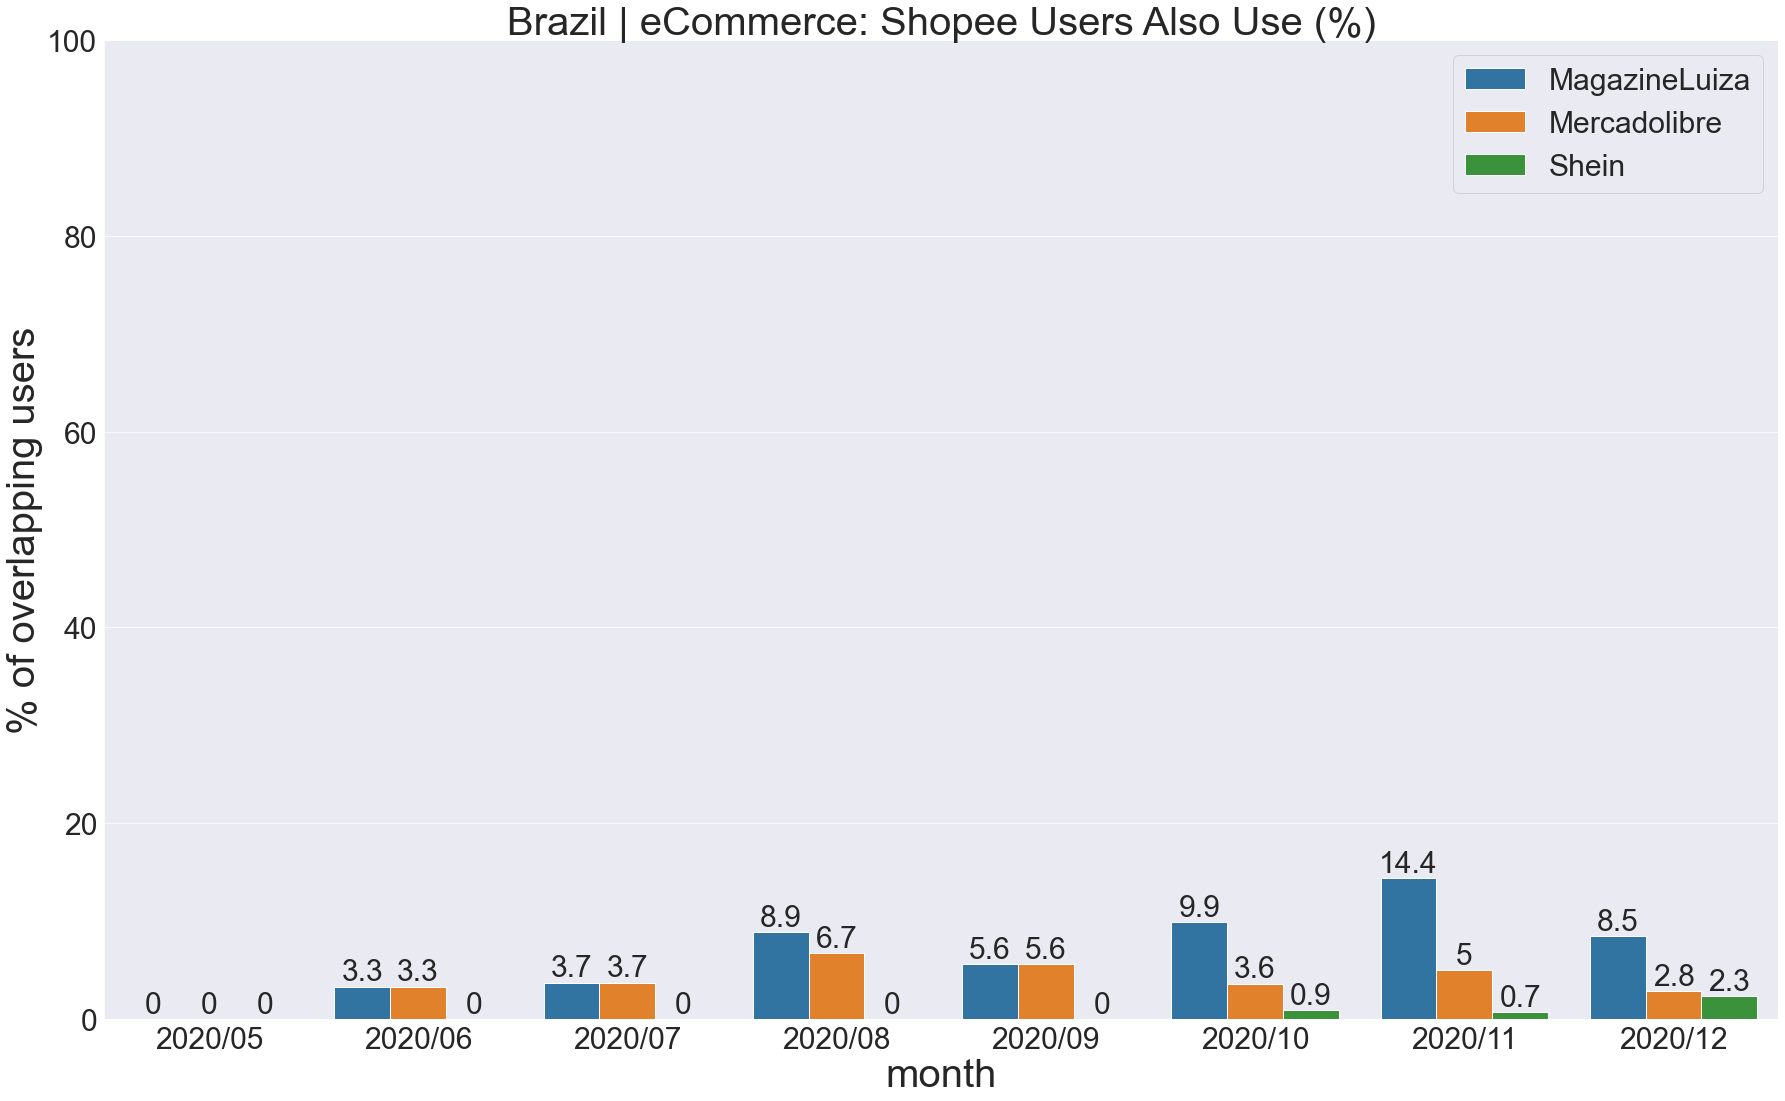

In [22]:
country = 'Brazil'
sector = 'eCommerce'
given_platform='Shopee'
freq = 'Q'
overlapping_platforms_with_sp = overlapping_platforms_given_platform(country, given_platform, sector, freq=freq)

freq='M'
overlapping_platforms_with_sp = overlapping_platforms_given_platform(country, given_platform, sector, freq=freq)

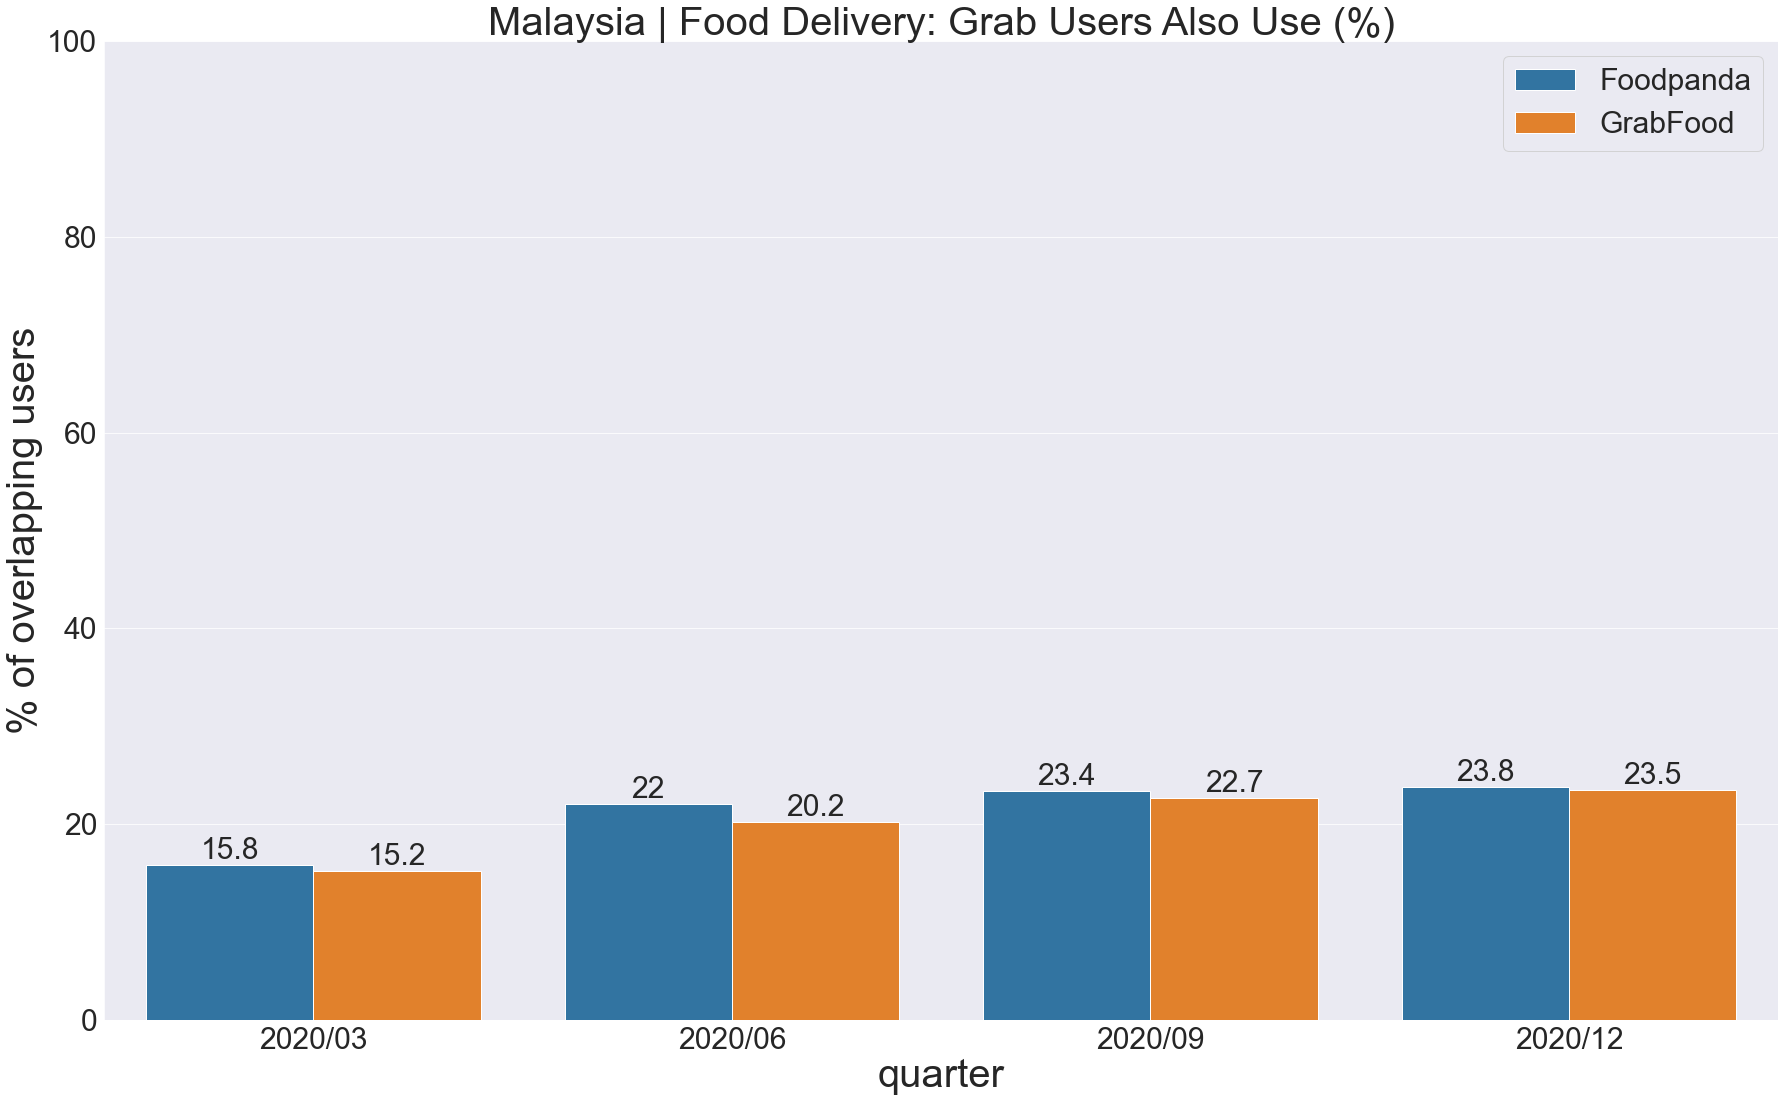

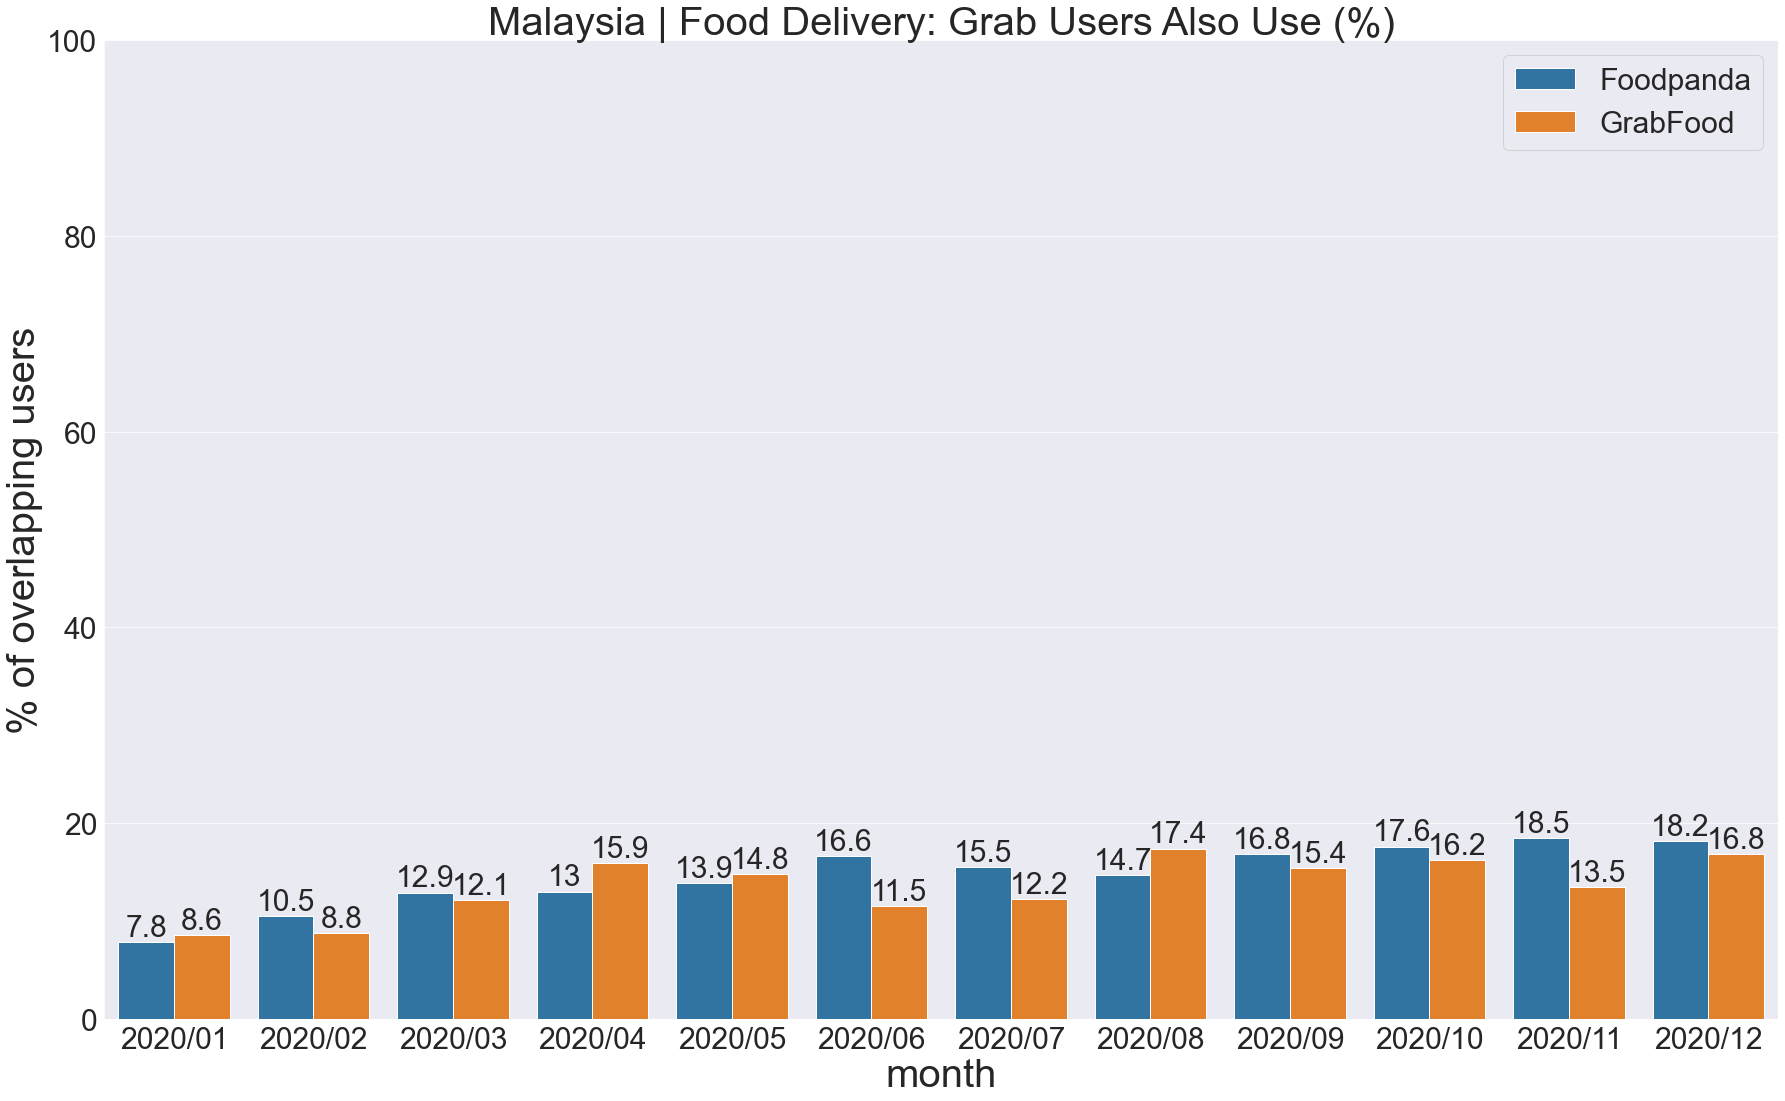

In [25]:
country= 'Malaysia'
sectors = ['Food Delivery']
given_platform = 'Grab'
freq = 'Q'
overlapping_user_grab = overlapping_platforms_given_platform_any_sectors(country, given_platform, sectors, freq=freq)

freq ='M'
overlapping_user_grab = overlapping_platforms_given_platform_any_sectors(country, given_platform, sectors, freq=freq)